# Action Space analysis for AWS DeepRacer
This notebook has been built for the [AWS DeepRacer-Analysis](https://github.com/aws-deepracer-community/deepracer-analysis.git) 
provided by  the [AWS DeepRacer Community](http://join.deepracing.io).

## Usage
Copy this Notebook to "work" folder in your allready installed [AWS DeepRacer-Analysis](https://github.com/aws-deepracer-community/deepracer-analysis.git)

**This notebook isn't complete.**
If you find some bugs, have problems with some tracks or something else
please report to @Kire in [AWS Machine Learning Community](https://aws-ml-community.slack.com) on #Slack

## Contributions
As usual, your ideas are very welcome and encouraged so if you have any suggestions either bring them
to [the AWS DeepRacer Community](http://join.deepracing.io) or share as code contributions.

## Requirements
Installed [AWS DeepRacer-Analysis](https://github.com/aws-deepracer-community/deepracer-analysis.git) 

## Credits
I would like to thank [the AWS DeepRacer Community](http://join.deepracing.io)

# Log Analysis

Let's get to it.

## Imports

Run the imports block below:

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from deepracer.tracks import TrackIO, Track
from deepracer.logs import \
    SimulationLogsIO as slio, \
    PlottingUtils as pu, \
    AnalysisUtils as au

# Ignore deprecation warnings we have no power over
import warnings
warnings.filterwarnings('ignore')

## Load waypoints for the track you want to run analysis on

Remeber that evaluation npy files are a community effort to visualise the tracks in the trainings, they aren't 100% accurate.

Tracks Available:

In [32]:
tu = TrackIO()

track_name = "2022_september_pro_cw"

fname = "logs/sep-cw-01-cw-cw3/logs/training/training-20230904201041-6t5yw91_TX-1M4SJItgk-Q-robomaker.log"

# for f in tu.get_tracks():
#     print(f)

Take the name from results above and paste below to load the key elements of the track and view the outline of it.

Loaded 203 waypoints


<Axes: >

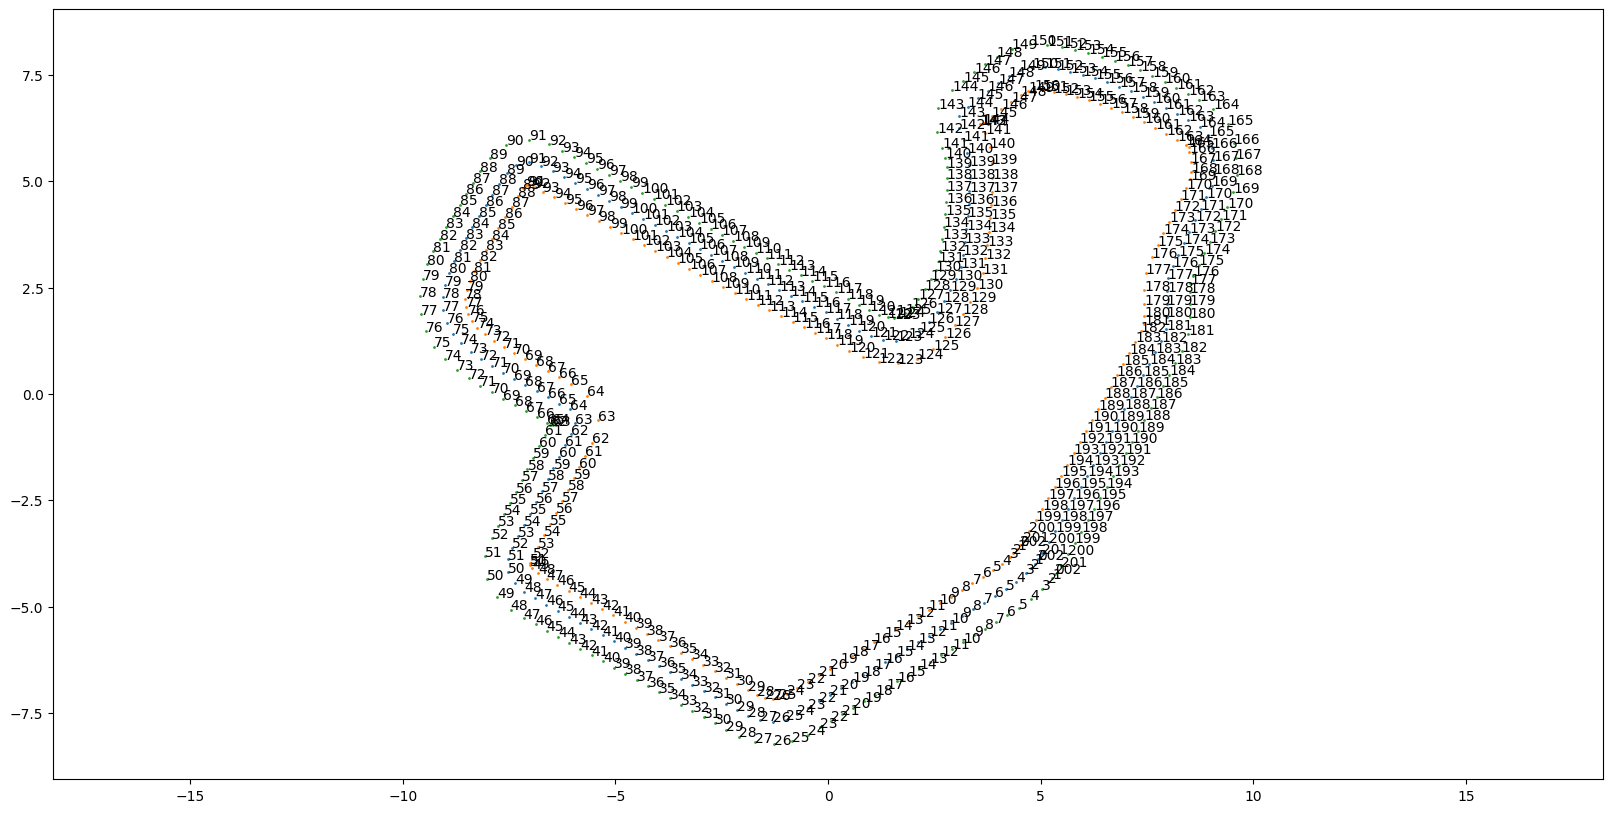

In [33]:
track: Track = tu.load_track(track_name)

l_track = track.center_line
l_outer_border = track.outer_border
l_inner_border = track.inner_border

pu.plot_trackpoints(track)

## Get the logs

Depending on which way you are training your model, you will need a different way to load the data.

**AWS DeepRacer Console**
The logs are being stored in CloudWatch, in group `/aws/robomaker/SimulationJobs`. You will be using boto3 to download them based on the training ID (stream name prefix). If you wish to bulk export the logs from Amazon Cloudwatch to Amazon S3 :: https://docs.aws.amazon.com/AmazonCloudWatch/latest/logs/S3ExportTasks.html

**DeepRacer for Dummies/ARCC local training**
Those two setups come with a container that runs Jupyter Notebook (as you noticed if you're using one of them and reading this text). Logs are stored in `/logs/` and you just need to point at the latest file to see the current training. The logs are split for long running training if they exceed 500 MB. The log loading method has been extended to support that.

**Chris Rhodes' repo**
Chris repo doesn't come with logs storage out of the box. I would normally run `docker logs dr > /path/to/logfile` and then load the file.

Below I have prepared a section for each case. In each case you can analyse the logs as the training is being run, just in case of the Console you may need to force downloading of the logs as the `cw.download_log` method has a protection against needless downloads.

Select your preferred way to get the logs below and you can get rid of the rest.

In [34]:
# AWS DeepRacer Console
# fname = 'logs/sample-model/logs/training/training-20230810103618-okmbJfUNS0utbfIMPRxURQ-robomaker.log'

## Load the trace training log

Now that the data is downloaded, we need to load it into memory. We will first read it from file and then convert to data frames in Pandas. [Pandas](https://pandas.pydata.org/) is a Python library for handling and analysing large amounts of data series. Remember this name, you may want to learn more about how to use it to get more information that you would like to get from the logs. Examples below are hardly scratching the surface.

One important information to enter is the setting of your Episodes per iteration hyperparameter. This is used to group the episodes into iterations. This information is valuable when later looking at graphs showing how the training progresses per iteration. You can use it to detect which iteration gave you better outcomes and, if in local training, you could move to that iteration's outcome for submissions in the AWS DeepRacer League or  for continuing the training.

The log files you have just gathered above have lines like this one:
```
SIM_TRACE_LOG:799,111,1.7594,4.4353,3.0875,-0.26,2.50,2,1.0000,False,True,71.5802,49,17.67,1555554451.1110387
```
This is all that matters for us. The first two are some tests I believe and when loading they get skipped, then each next line has the following fields:
* episode number
* step number
* x coordinate
* y coordinate
* yaw of the car (where the car is heading)
* decision about turning (turn value from your action space)
* decision about throttle (speed value from your action space)
* decision index (value from your action space)
* reward value
* is the car going backwards
* are all wheels on track?
* progress in the lap
* closest waypoint
* track length
* timestamp

`la.load_data` and then `la.convert_to_pandas` read it and prepare for your usage. Sorting the values may not be needed, but I have experienced under some circumstances that the log lines were not ordered properly.

In [35]:
EPISODES_PER_ITERATION = 20  #  Set to value of your hyperparameter in training

data = slio.load_data(fname)
df = slio.convert_to_pandas(data, episodes_per_iteration=EPISODES_PER_ITERATION)

df = df.sort_values(["episode", "steps"])
# personally I think normalizing can mask too high rewards so I am commenting it out,
# but you might want it.
# slio.normalize_rewards(df)

# Uncomment the line of code below to evaluate a different reward function
# nr.new_reward(df, l_center_line, 'reward.reward_sample') #, verbose=True)

In [36]:
simulation_agg = au.simulation_agg(df)
au.analyze_training_progress(simulation_agg, title="Training progress")

new reward not found, using reward as its values
Number of episodes =  379
Number of iterations =  19


<Figure size 640x480 with 0 Axes>

In [37]:
au.scatter_aggregates(simulation_agg, 'Stats for all laps')

<Figure size 640x480 with 0 Axes>

In [38]:
complete_ones = simulation_agg[simulation_agg["progress"] == 100]

if complete_ones.shape[0] > 0:
    au.scatter_aggregates(complete_ones, "Stats for complete laps")
else:
    print("No complete laps yet.")

<Figure size 640x480 with 0 Axes>

In [39]:
# View five fastest complete laps
complete_ones.nsmallest(5, 'time')

iteration  episode  steps  start_at  progress    time       dist   
52          3       52    385       122     100.0  25.608  57.320477  \
20          2       20    388         1     100.0  25.788  57.748231   
60          4       60    388         1     100.0  25.789  57.588791   
4           1        4    398        42     100.0  26.467  58.261349   

    new_reward     speed     reward  time_if_complete  reward_if_complete   
52   1709.0413  2.274545  1709.0413            25.608           1709.0413  \
20   1517.4457  2.342784  1517.4457            25.788           1517.4457   
60   1595.3324  2.340464  1595.3324            25.789           1595.3324   
4    1801.5600  2.301005  1801.5600            26.467           1801.5600   

   quintile  complete  
52      1st         1  
20      1st         1  
60      1st         1  
4       1st         1

In [40]:
# View five best rewarded in completed laps (according to new_reward if you are using it)
complete_ones.nlargest(5, 'reward')

iteration  episode  steps  start_at  progress    time       dist   
4           1        4    398        42     100.0  26.467  58.261349  \
52          3       52    385       122     100.0  25.608  57.320477   
60          4       60    388         1     100.0  25.789  57.588791   
20          2       20    388         1     100.0  25.788  57.748231   

    new_reward     speed     reward  time_if_complete  reward_if_complete   
4    1801.5600  2.301005  1801.5600            26.467           1801.5600  \
52   1709.0413  2.274545  1709.0413            25.608           1709.0413   
60   1595.3324  2.340464  1595.3324            25.789           1595.3324   
20   1517.4457  2.342784  1517.4457            25.788           1517.4457   

   quintile  complete  
4       1st         1  
52      1st         1  
60      1st         1  
20      1st         1

In [41]:
# View five most progressed episodes
simulation_agg.nlargest(5, 'progress')

iteration  episode  steps  start_at  progress    time       dist   
4            1        4    398        42  100.0000  26.467  58.261349  \
20           2       20    388         1  100.0000  25.788  57.748231   
52           3       52    385       122  100.0000  25.608  57.320477   
60           4       60    388         1  100.0000  25.789  57.588791   
148          8      148    374        82   92.3795  24.873  54.284340   

     new_reward     speed     reward  time_if_complete  reward_if_complete   
4     1801.5600  2.301005  1801.5600         26.467000          1801.56000  \
20    1517.4457  2.342784  1517.4457         25.788000          1517.44570   
52    1709.0413  2.274545  1709.0413         25.608000          1709.04130   
60    1595.3324  2.340464  1595.3324         25.789000          1595.33240   
148   1463.5233  2.285561  1463.5233         26.924805          1584.25116   

    quintile  complete  
4        1st         1  
20       1st         1  
52       1st         1  
60       1st         1  
148      2nd         0

In [42]:
# View information for a couple last episodes
simulation_agg.tail()

iteration  episode  steps  start_at  progress    time       dist   
375         19      375    222       152   55.6845  14.752  33.613993  \
376         19      376    176       162   46.1704  11.661  27.269721   
377         19      377     44       172   11.4072   2.882   6.656154   
378         19      378    136       182   35.1872   8.967  21.319800   
379         19      379     98       192   27.8964   6.469  16.731722   

     new_reward     speed    reward  time_if_complete  reward_if_complete   
375    907.5478  2.481532  907.5478         26.492112         1629.803267  \
376    649.1067  2.467614  649.1067         25.256441         1405.893603   
377    140.3931  2.811364  140.3931         25.264745         1230.741111   
378    436.1420  2.577941  436.1420         25.483699         1239.490497   
379    376.7503  2.732653  376.7503         23.189372         1350.533761   

    quintile  complete  
375      5th         0  
376      5th         0  
377      5th         0  
378      5th         0  
379      5th         0

In [43]:
one = complete_ones.nsmallest(1, "time")

ITERATION = int(one.iloc[0]["iteration"])
EPISODE = int(one.iloc[0]["episode"])

# Set maximum quantity of rows to view for a dataframe display - without that
# the view below will just hide some of the steps
pd.set_option("display.max_rows", 500)

# View all steps data for episode 10
df[df["episode"] == EPISODE]

iteration  episode  steps       x       y       yaw  steering_angle   
6103          3       52      1  1.2959  1.2730  -17.4769            -8.0  \
6104          3       52      2  1.2960  1.2733  -17.4266            16.0   
6105          3       52      3  1.3014  1.2704  -17.8216            16.0   
6106          3       52      4  1.3232  1.2682  -16.7032            16.0   
6107          3       52      5  1.3599  1.2667  -14.4776            16.0   
6108          3       52      6  1.4142  1.2664  -11.4433            16.0   
6109          3       52      7  1.4863  1.2695   -7.6170            16.0   
6110          3       52      8  1.5380  1.2766   -4.4078            16.0   
6111          3       52      9  1.6111  1.2904   -0.1359            16.0   
6112          3       52     10  1.6839  1.3081    3.7831            16.0   
6113          3       52     11  1.7632  1.3337    8.2206            16.0   
6114          3       52     12  1.8378  1.3651   12.6622            16.0   
6115          3       52     13  1.9087  1.4018   17.1055            16.0   
6116          3       52     14  1.9758  1.4438   21.5897             0.0   
6117          3       52     15  2.0517  1.4935   25.8652             0.0   
6118          3       52     16  2.1337  1.5389   27.0401            16.0   
6119          3       52     17  2.2159  1.5893   28.5808            16.0   
6120          3       52     18  2.2945  1.6541   32.7140            16.0   
6121          3       52     19  2.3484  1.7157   37.7522            16.0   
6122          3       52     20  2.4012  1.7908   43.6918            24.0   
6123          3       52     21  2.4489  1.8891   52.2279            24.0   
6124          3       52     22  2.4928  2.0506   66.4699             0.0   
6125          3       52     23  2.5099  2.1284   72.1985             8.0   
6126          3       52     24  2.5411  2.2699   78.5980            -8.0   
6127          3       52     25  2.5740  2.4319   82.0537           -16.0   
6128          3       52     26  2.6122  2.5522   79.8100           -16.0   
6129          3       52     27  2.6749  2.7081   72.7711           -30.0   
6130          3       52     28  2.7538  2.8599   63.9338            24.0   
6131          3       52     29  2.8334  3.0140   57.9679            24.0   
6132          3       52     30  2.8711  3.1052   58.3026            24.0   
6133          3       52     31  2.9159  3.2396   63.0112             8.0   
6134          3       52     32  2.9434  3.3619   69.8361            24.0   
6135          3       52     33  2.9627  3.5071   76.5835           -24.0   
6136          3       52     34  2.9832  3.6557   80.1137            24.0   
6137          3       52     35  3.0075  3.7886   80.2059           -24.0   
6138          3       52     36  3.0339  3.9355   79.7589           -24.0   
6139          3       52     37  3.0867  4.1020   75.4520            24.0   
6140          3       52     38  3.1281  4.2351   74.0787             8.0   
6141          3       52     39  3.1603  4.4038   76.9680            24.0   
6142          3       52     40  3.1794  4.5507   79.8953           -30.0   
6143          3       52     41  3.1864  4.6903   83.4717            24.0   
6144          3       52     42  3.1940  4.8379   85.3600            -8.0   
6145          3       52     43  3.2056  4.9492   84.7613           -16.0   
6146          3       52     44  3.2263  5.0442   82.1878             8.0   
6147          3       52     45  3.2549  5.1529   79.2976            16.0   
6148          3       52     46  3.2701  5.2793   81.1326            16.0   
6149          3       52     47  3.2672  5.3749   84.9617            -8.0   
6150          3       52     48  3.2631  5.4914   87.8631           -24.0   
6151          3       52     49  3.2747  5.6323   87.1391           -16.0   
6152          3       52     50  3.2915  5.7390   84.7053            -8.0   
6153          3       52     51  3.3257  5.8685   80.1571           -16.0   
61

# Extract Action Space List from LOG file

In [44]:
# Extract Action Space List
dgr_norm = 1  # for degrees

if df["steering_angle"].max() < 2:
    dgr_norm = 57.6923  # for radians


class act(object):
    def __init__(self, index=None, steer=None, throttle=None, rel_thr=None, color=([0, 0, 0])):
        self.index = index
        self.steer = steer
        self.throttle = throttle  # relative throttle, max = 1
        self.rel_thr = rel_thr
        self.color = color


maxThrottle = df.speed.max()

# AS = df[df['steps'] != 0].groupby(['action'], as_index=False)['steering_angle','speed'].median()
AS = df[df["steps"] != 0].groupby(["action"], as_index=False)[["steering_angle", "speed"]].median()

asl = [None] * AS.shape[0]
for i in range(0, AS.shape[0]):
    j = AS.action[i].astype(int)
    # asl[AS.action[i].astype(int)] = [AS.action[i].astype(int), round(AS.steer[i]*dgr_norm,2), round(AS.throttle[i],2)]
    asl[j] = act(j, round(AS.steering_angle[i] * dgr_norm, 2), round(AS.speed[i], 2))
    asl[j].rel_thr = AS.speed[i] / maxThrottle

    cr = 8 * max(0, np.sign(asl[j].steer)) * abs(asl[j].steer) / 255
    cg = (0 + 6 * (30 - abs(asl[j].steer))) / 255
    cb = -8 * min(0, np.sign(asl[j].steer)) * abs(asl[j].steer) / 255

    asl[AS.action[i].astype(int)].color = [cr, cg, cb]

asMaxY = maxThrottle + 1

#########################################################
# define some constants for track graphs
trkFrame = 50

trkPlotXmin = df.x.min() - trkFrame
trkPlotXmax = df.x.max() + trkFrame
trkPlotYmin = df.y.min() - trkFrame
trkPlotYmax = df.y.max() + trkFrame

trkPlotXmin = min(l_outer_border[:, 0]) - trkFrame
trkPlotXmax = max(l_outer_border[:, 0]) + trkFrame
trkPlotYmin = min(l_outer_border[:, 1]) - trkFrame
trkPlotYmax = max(l_outer_border[:, 1]) + trkFrame

trkSizeX = int(trkPlotXmax - trkPlotXmin)
trkSizeY = int(trkPlotYmax - trkPlotYmin)

trkShiftX = int(trkSizeX - trkPlotXmax)
trkShiftY = int(trkSizeY - trkPlotYmax)

# print(trkSizeX,trkSizeY,trkPlotYmin,trkPlotYmax)

##########################################################
# define some constants for Action Space graphs

asPlotXmin = round(df.steering_angle.min() * dgr_norm, 2)
asPlotXmax = round(df.steering_angle.max() * dgr_norm, 2)
asPlotYmin = round(df.speed.min(), 2)
asPlotYmax = round(df.speed.max(), 2)

# df.throttle.min()
# print(asPlotXmin,asPlotXmax,asPlotYmin,asPlotYmax)

###############################################################

print("Actions: \nindex\t\tsteering\tthrottle")
for obj in asl:
    print(obj.index, obj.steer, obj.throttle, sep="\t\t")

Actions: 
index		steering	throttle
0		-30.0		1.1
1		-24.0		1.1
2		-24.0		1.8
3		-24.0		2.5
4		-16.0		1.1
5		-16.0		1.8
6		-16.0		2.5
7		-16.0		3.2
8		-8.0		1.1
9		-8.0		1.8
10		-8.0		2.5
11		-8.0		3.2
12		-8.0		3.8
13		0.0		3.8
14		0.0		3.2
15		0.0		2.5
16		0.0		1.8
17		8.0		3.8
18		8.0		3.2
19		8.0		2.5
20		8.0		1.8
21		8.0		1.1
22		16.0		3.2
23		16.0		2.5
24		16.0		1.8
25		16.0		1.1
26		24.0		2.5
27		24.0		1.8
28		24.0		1.1
29		30.0		1.1


## Function definitions

In [45]:
## Action Index Map
def plot_index_map(actSpaceList):
    fig = plt.figure(figsize=(7, 4))
    ax = fig.add_subplot(111)
    for obj in actSpaceList:
        N = 100
        ax.set_title("Action Index Map")
        ax.axis([-35, 35, 0, asMaxY])
        ax.set(xlabel="Steering", ylabel="Speed", xlim=(35, -35))
        scatter = ax.scatter((0.0 + obj.steer), (0.0 + obj.throttle), color=obj.color, s=1200 * obj.rel_thr, alpha=0.85)
        ax.text(
            (0.5 - obj.steer / 70),
            (0.0 + obj.throttle / asMaxY),
            obj.index,
            verticalalignment="center",
            horizontalalignment="center",
            transform=ax.transAxes,
            color="w",
            fontsize=15,
        )
    plt.show()


### Action space histograms


# 4 in 1 Histograms
def plot_4_hist(df, itr=-1, E=-1):
    if itr > -1:
        episode_data = df[df["iteration"] == itr]
        print("Histograms for iteration:", itr)
    else:
        if E > -1:
            episode_data = df[df["episode"] == E]
            print("Histograms for episode:", E)
        else:
            episode_data = df[:]
            print("Histograms for all episodes:")
    fig, axs = plt.subplots(2, 2, sharex="col", figsize=(14, 10), sharey="row", gridspec_kw={"hspace": 0, "wspace": 0})
    (ax1, ax2), (ax3, ax4) = axs
    ax3.hist2d(episode_data["steering_angle"] * (dgr_norm), episode_data["speed"], bins=(63, 56), range=[[-31, 31], [0, asMaxY]])
    ax3.set(xlabel="Steering", ylabel="Speed", xlim=(31, -31))
    ax2 = plt.subplot(222, polar=True)
    ax2.set_theta_zero_location("N")
    ax2.hist2d(episode_data["steering_angle"] * (dgr_norm / 57.6923), episode_data["speed"], bins=(90, 23), range=[[-1.57, 1.57], [0, asMaxY]])
    # ax2.hist(episode_data['action']*dgr_norm, bins=60)
    ax1.hist(episode_data["steering_angle"] * dgr_norm, bins=60)
    ax4.hist(episode_data["speed"], bins=50, orientation="horizontal")  # steer - throttle - actions
    for ax in fig.get_axes():
        ax.label_outer()


## Big Polar 2D Histogram
def plot_polar_hist(df, itr=-1, E=-1):
    if itr > -1:
        episode_data = df[df["iteration"] == itr]
        print("Histograms for iteration:", itr)
    else:
        if E > -1:
            episode_data = df[df["episode"] == E]
            print("Histograms for episode:", E)
        else:
            episode_data = df[:]
            print("Histogram for all episodes:")
    fig2 = plt.figure(1, figsize=(7, 7))
    bx = fig2.add_subplot(111, polar=True)
    bx.set_theta_zero_location("N")
    bx.hist2d(episode_data["steering_angle"] * (dgr_norm / 57.6923), episode_data["speed"], bins=(90, 25), range=[[-1.57, 1.57], [0, asMaxY]])


## Ploting steps in the episodes with red dots
def plot_episode_red(df, E):  # , center_line, inner_border, outer_border):
    fig = plt.figure(1, figsize=(trkSizeX / 5, trkSizeY / 5))
    ax = fig.add_subplot(211)
    ax.set_aspect(aspect=1)
    pu.print_border(ax, track, color="WhiteSmoke")  # center_line, inner_border, outer_border)
    episode_data = df[df["episode"] == E]
    for row in episode_data.iterrows():
        x1, y1, action, reward = row[1]["x"], row[1]["y"], row[1]["action"], row[1]["reward"]
        car_x2, car_y2 = x1 - 0.02, y1
        plt.plot([x1, car_x2], [y1, car_y2], "r.")


## Ploting steps in the episodes with dots of different colors and sizes
def plot_episode_color(df, E):  # , center_line, inner_border, outer_border):
    fig = plt.figure(1, figsize=(trkSizeX / 5, trkSizeY / 5))
    ax = fig.add_subplot(211)
    ax.set_aspect(aspect=1)
    pu.print_border(ax, track, color="WhiteSmoke")  # center_line, inner_border, outer_border)
    episode_data = df[df["episode"] == E]
    for row in episode_data.iterrows():
        x1, y1, action, reward = row[1]["x"], row[1]["y"], row[1]["action"], row[1]["reward"]
        actidx = int(action)
        action_color = asl[int(action)].color
        action_s = (asl[int(action)].throttle / maxThrottle) ** 2 * 50  # tune the size of the dots
        # print(action_color)
        # plt.scatter([x1, car_x2], [y1, car_y2], color=action_color, s=action_s, alpha=0.65)
        plt.scatter(x1, y1, color=action_color, s=action_s, alpha=0.75)

# Action Space Visualization

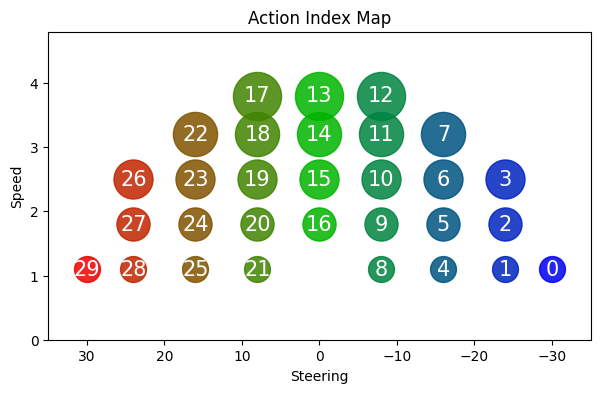

In [46]:
plot_index_map(asl)    

# Analysing data from all episodes

In [47]:
tr_plot = pu.plot_track(df, track, value_field="reward") 

<Figure size 640x480 with 0 Axes>

Histograms for all episodes:


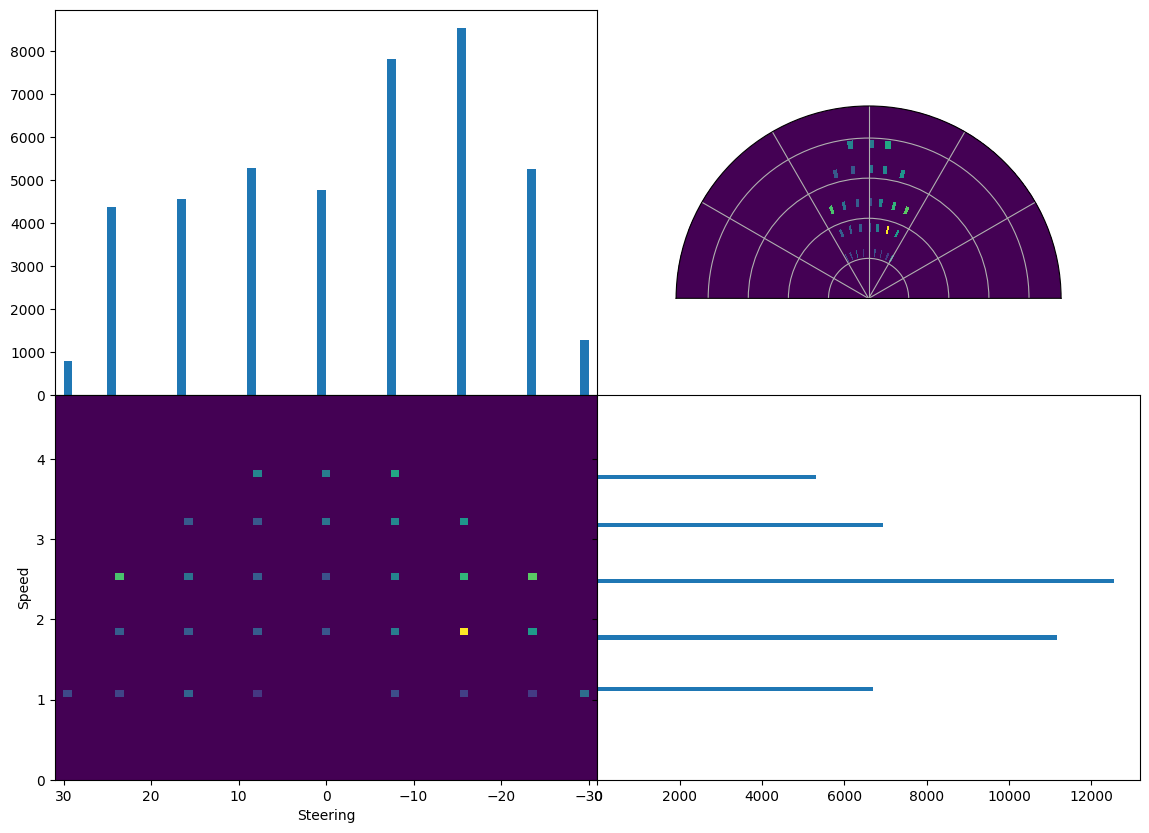

In [48]:
plot_4_hist(df)

Histogram for all episodes:


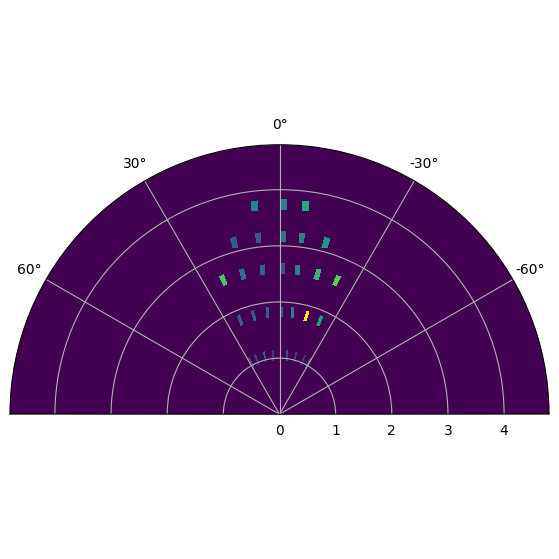

In [49]:
plot_polar_hist(df)



# Analyzing specific iteration





In [50]:
# Set iteration id
itr = ITERATION                        # iteration id
# itr = df['iteration'].max() - 5  # last iteration

In [51]:
for i in range((itr-1)*EPISODES_PER_ITERATION, (itr)*EPISODES_PER_ITERATION):
    plot_episode_red(df,i) #,l_inner_border, l_inner_border, l_outer_border)
print('Iteration:',itr)

Iteration: 3


Histograms for iteration: 3


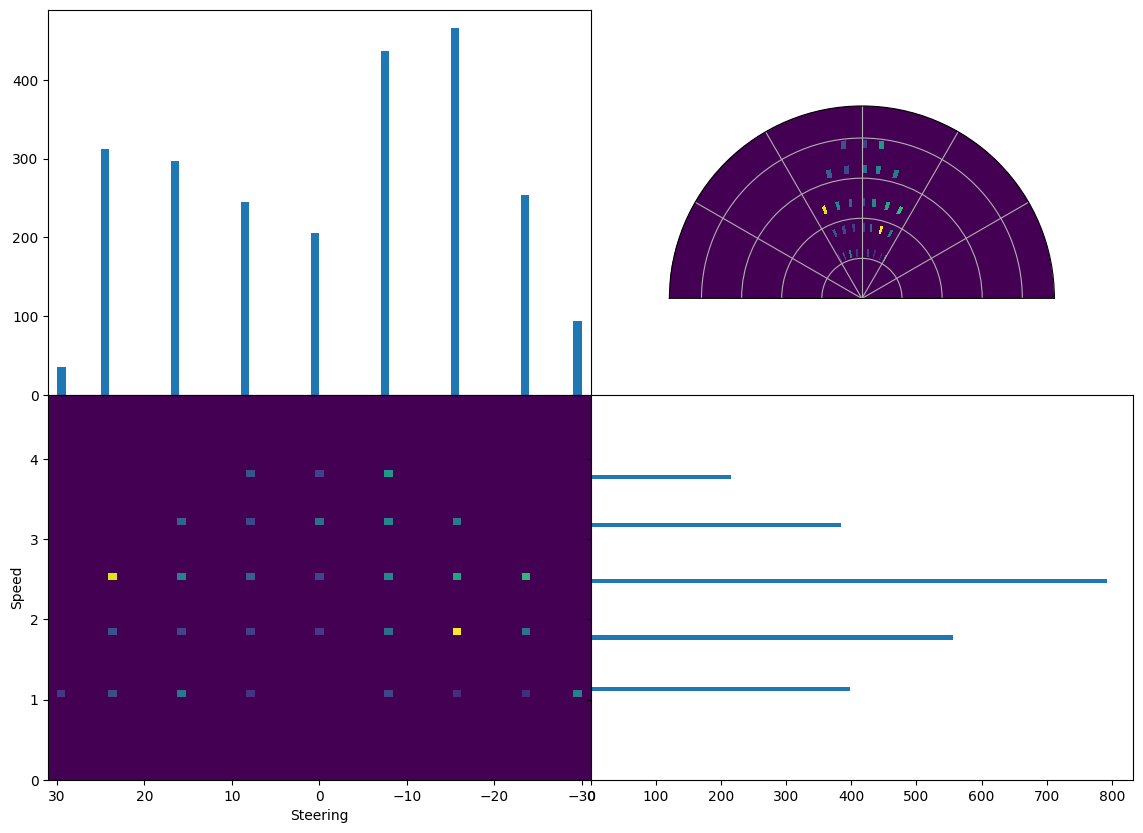

In [52]:
#plot_episode_as_hist(df, itr=25)  # specific iteration
plot_4_hist(df, itr)  # last iteration

Histograms for iteration: 3


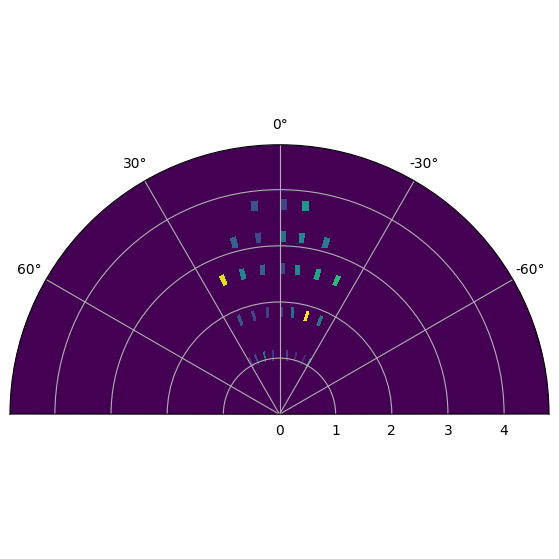

In [53]:
plot_polar_hist(df, itr)



# Analyzing specific episode



In [54]:
### choose episode id
EPZ = EPISODE

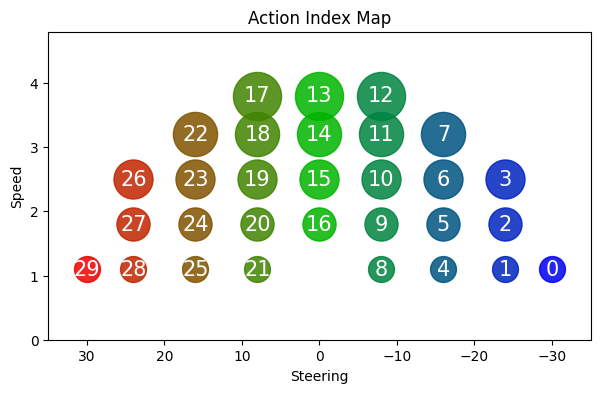

In [55]:
# Plot Index Map to understand graph
plot_index_map(asl)

Every dot is one step. Dot size is proportional to the throttle
Colors: Green = Straight, Red = Steering Left, Blue = Steering Right


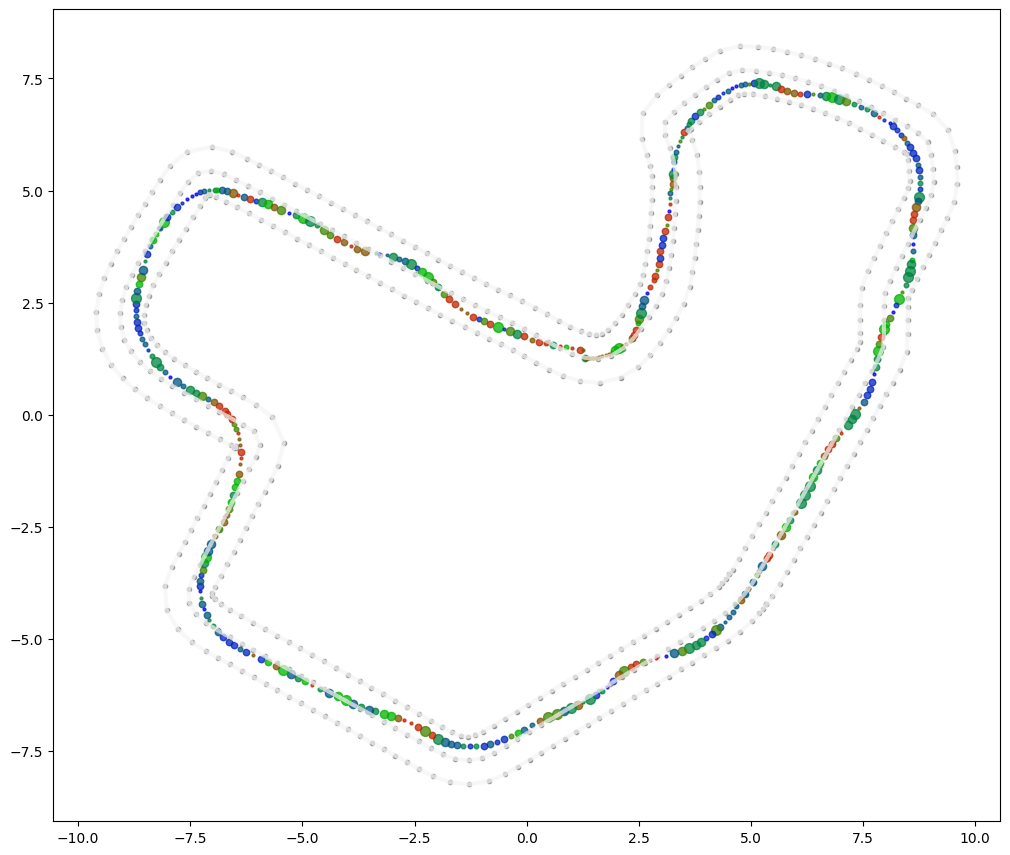

In [56]:
print("Every dot is one step. Dot size is proportional to the throttle")
print("Colors: Green = Straight, Red = Steering Left, Blue = Steering Right")
plot_episode_color(df,EPZ) #, l_inner_border, l_inner_border, l_outer_border) # arbitrary episode

Histograms for episode: 52


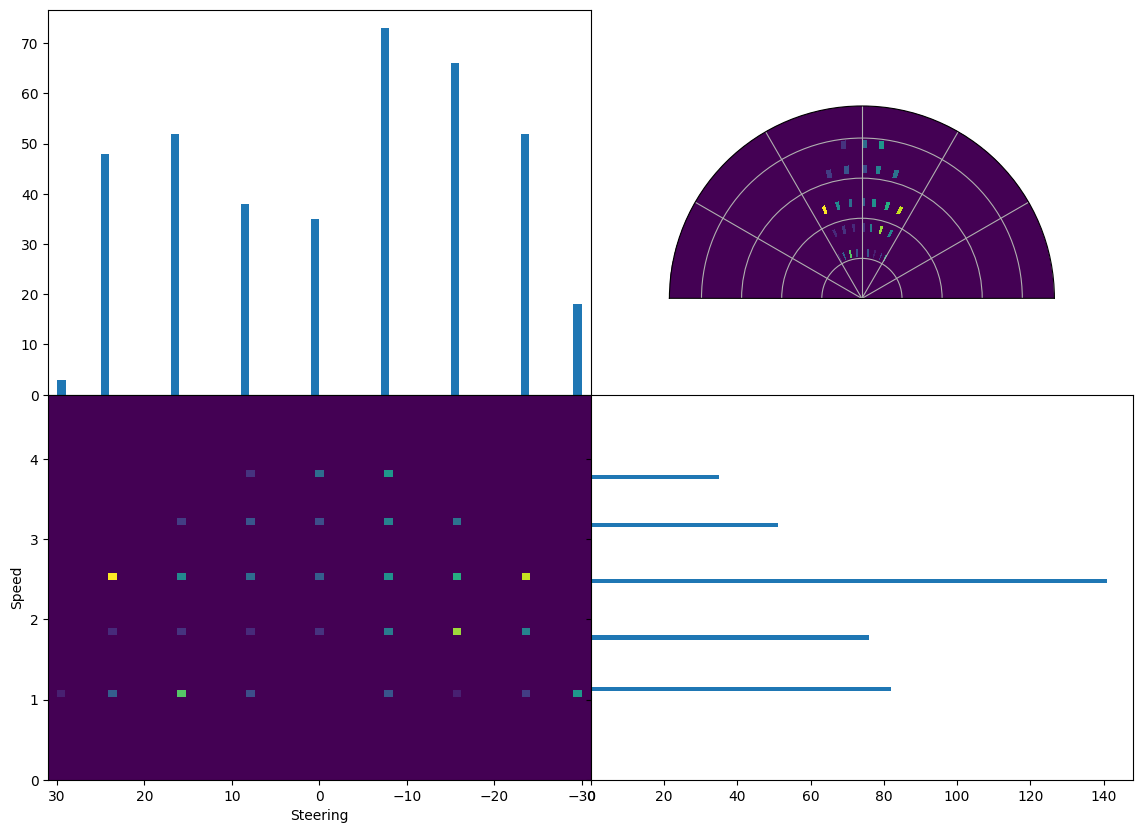

In [57]:
plot_4_hist(df, E = EPZ)

Histograms for episode: 52


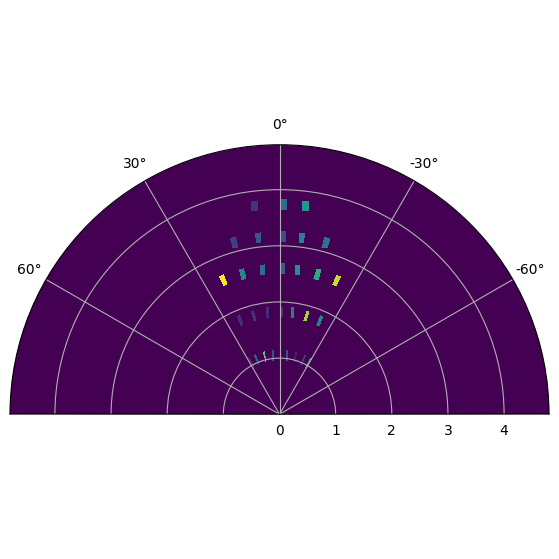

In [58]:
plot_polar_hist(df, E = EPZ)

<Axes: xlabel='closest_waypoint'>

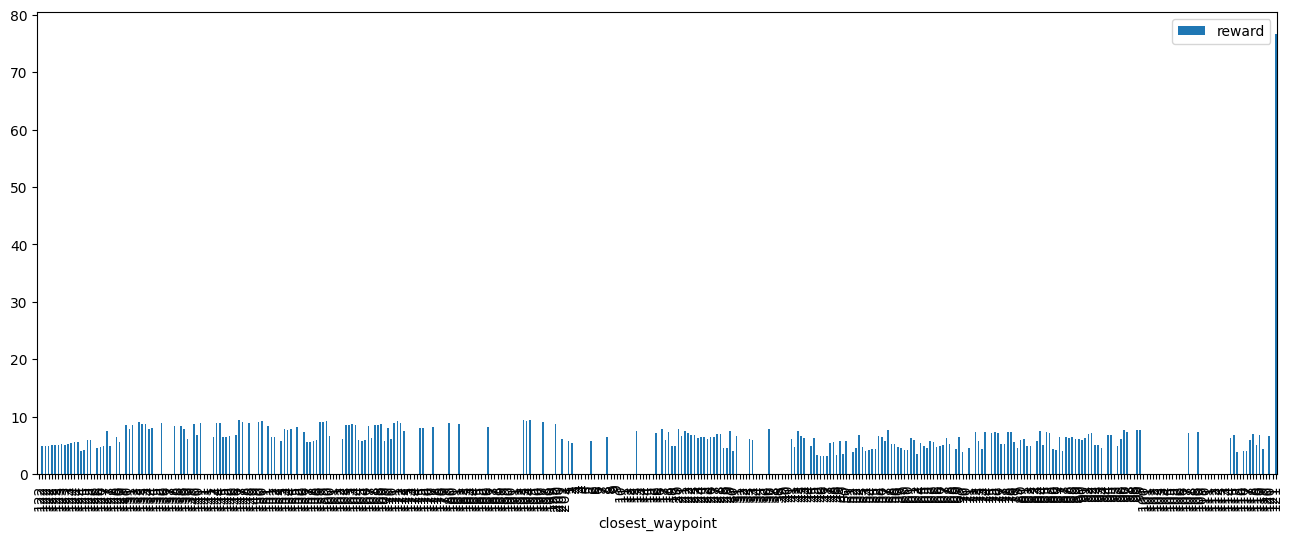

In [59]:
# This shows a histogram of actions per waypoint. Will let you spot potentially problematic places
episode = df[df["episode"] == EPZ]
episode[:-1].plot.bar(x="closest_waypoint", y="reward", figsize=(16, 6))

# Analyzing Actions
## You can analyze all actions or only set of actions with indexes defined in setActions



 Heatmap for action with index 0: steering: -30.0, throttle: 1.1


<Figure size 640x480 with 0 Axes>

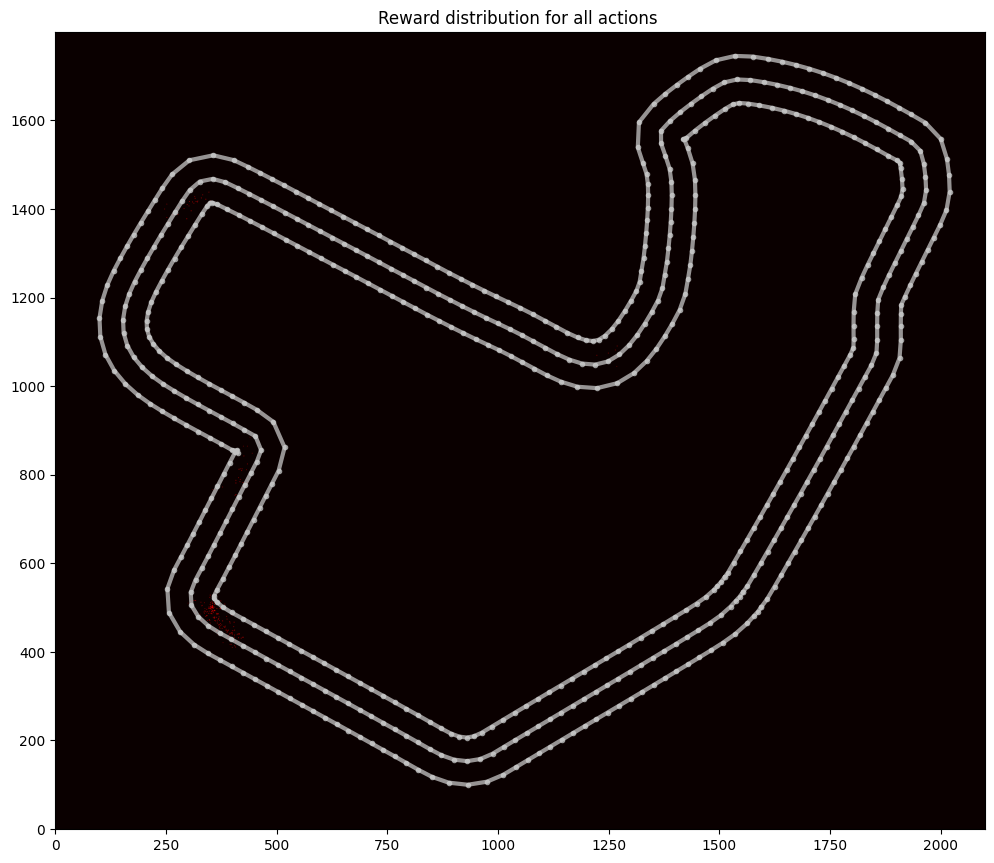

<Figure size 640x480 with 0 Axes>



 Heatmap for action with index 1: steering: -24.0, throttle: 1.1


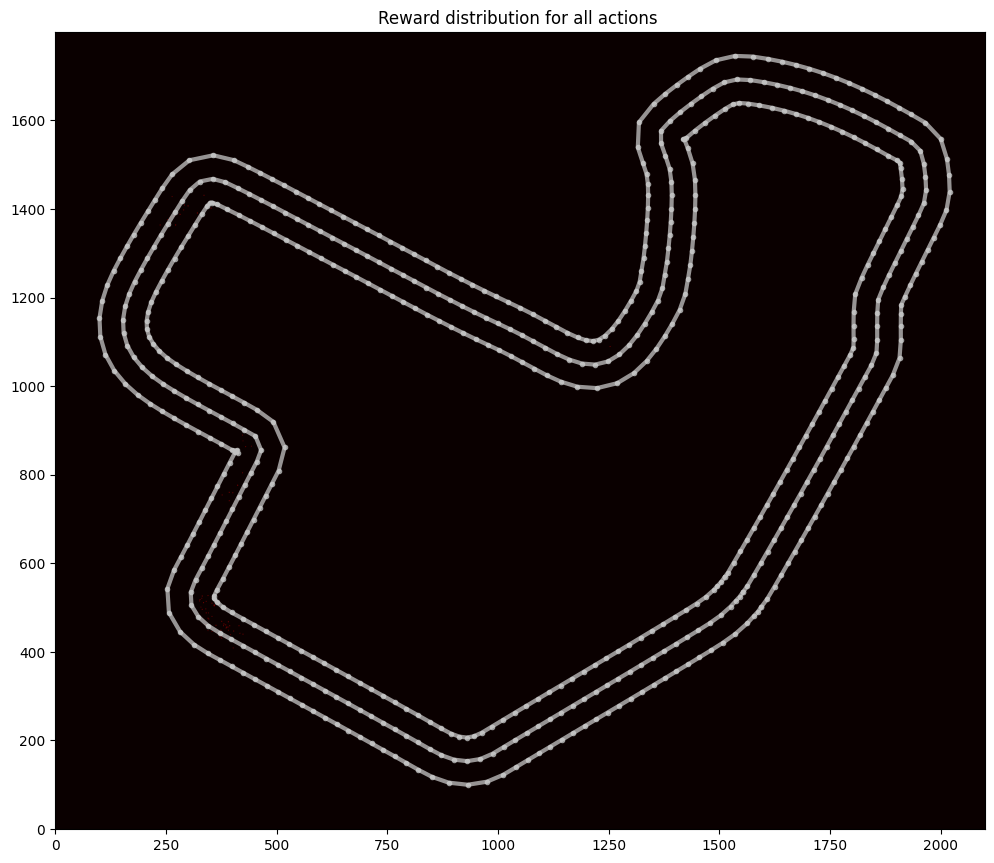

<Figure size 640x480 with 0 Axes>



 Heatmap for action with index 2: steering: -24.0, throttle: 1.8


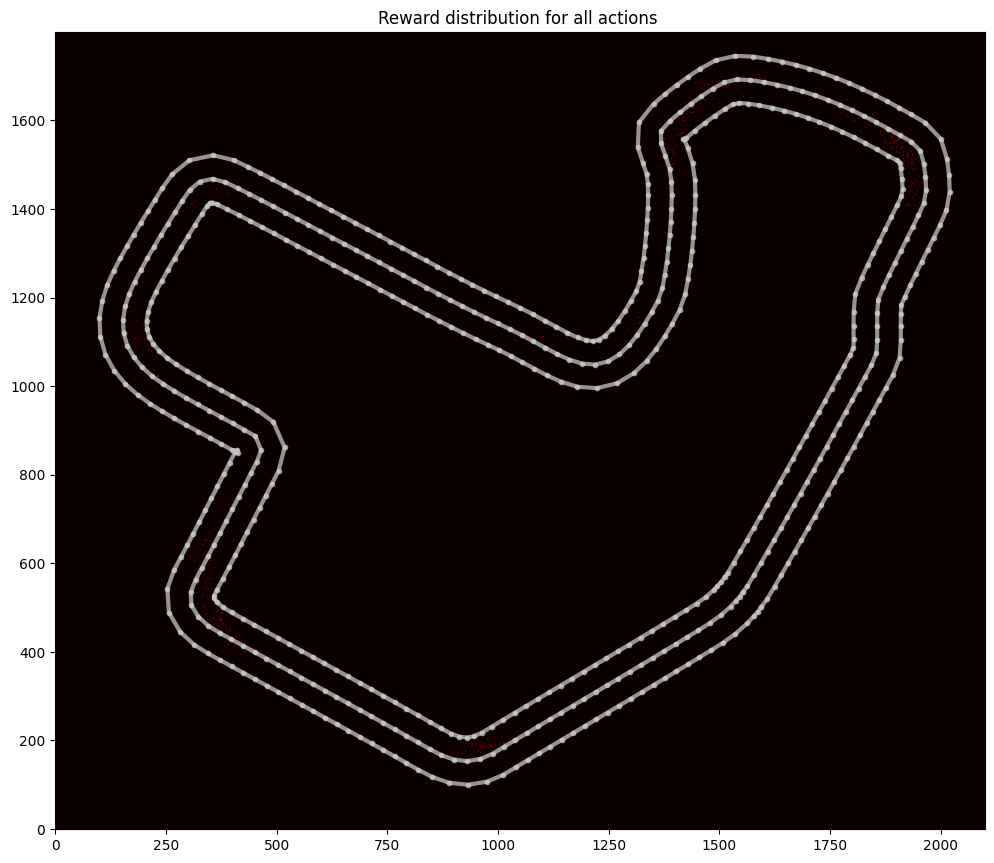

<Figure size 640x480 with 0 Axes>



 Heatmap for action with index 3: steering: -24.0, throttle: 2.5


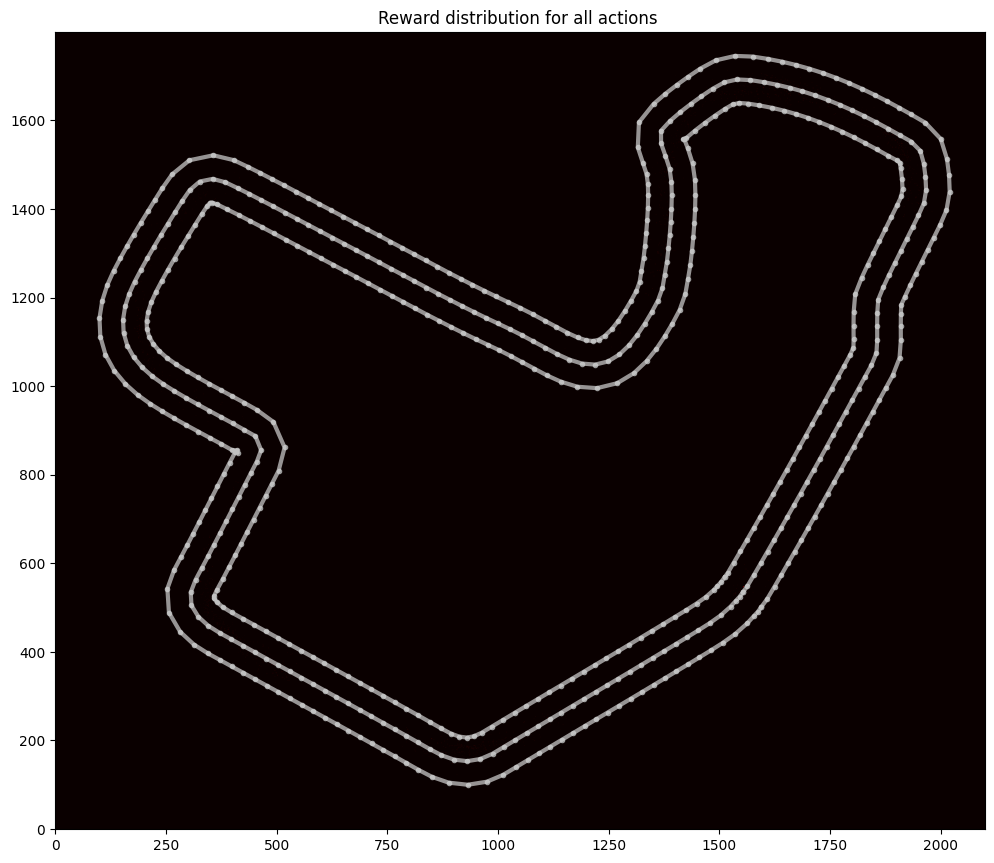

<Figure size 640x480 with 0 Axes>



 Heatmap for action with index 4: steering: -16.0, throttle: 1.1


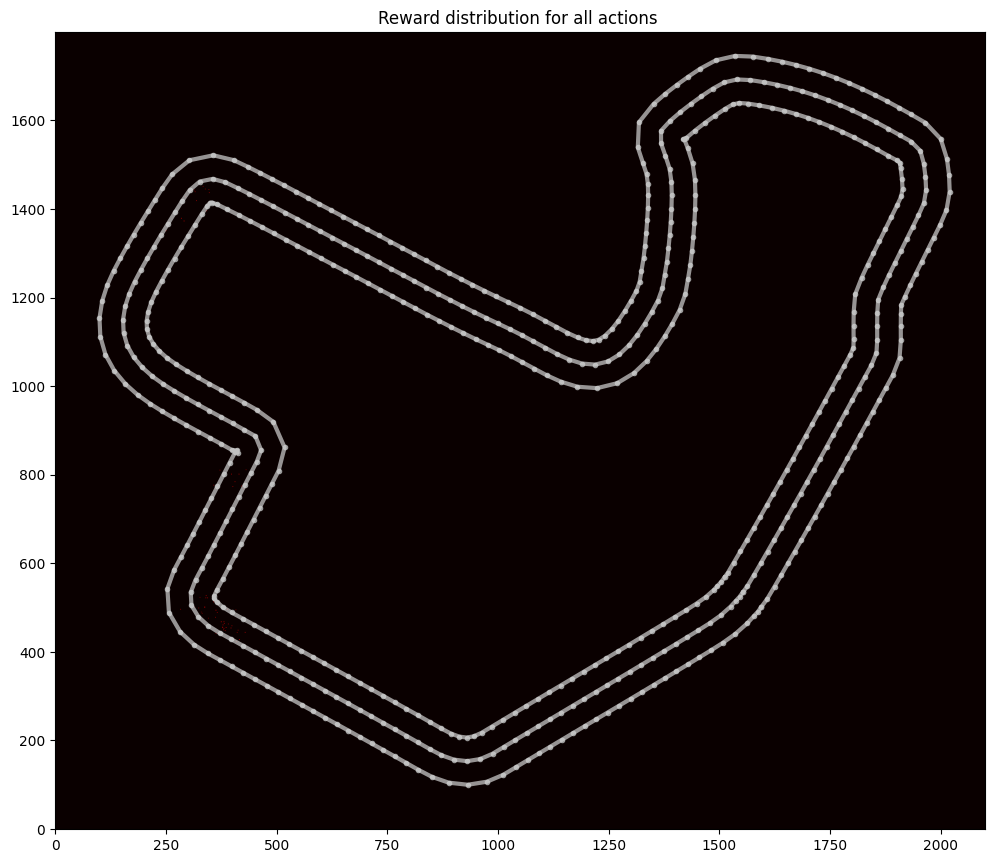

<Figure size 640x480 with 0 Axes>



 Heatmap for action with index 5: steering: -16.0, throttle: 1.8


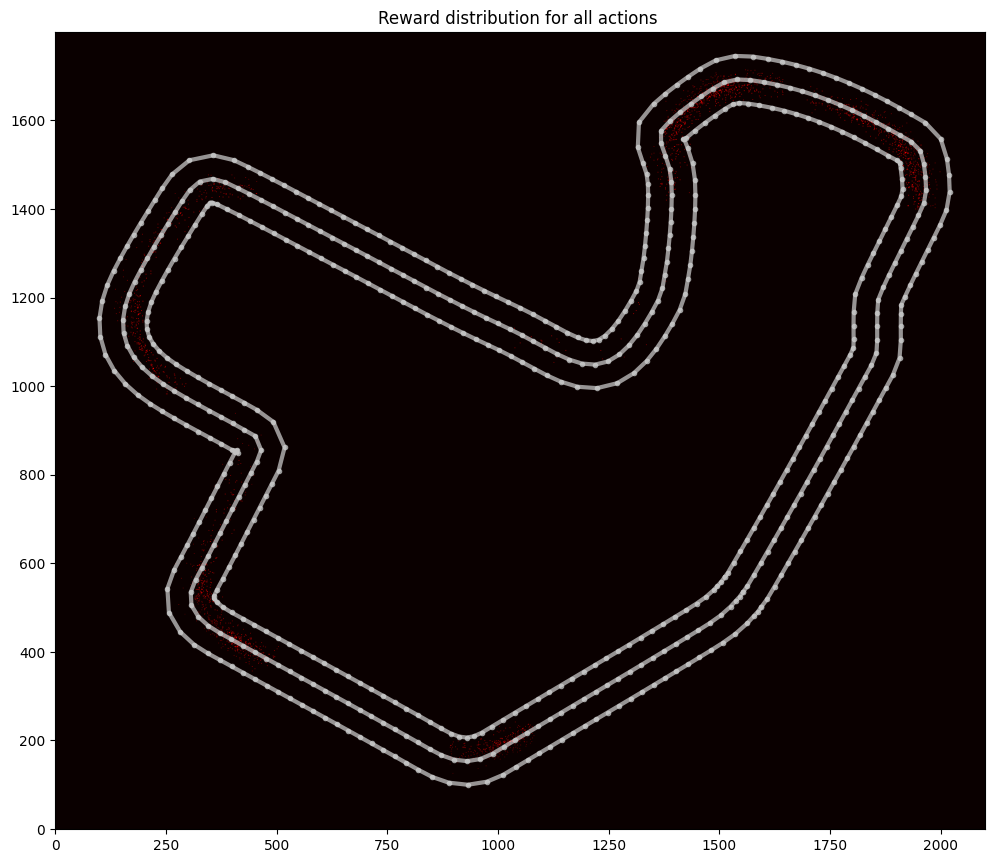

<Figure size 640x480 with 0 Axes>



 Heatmap for action with index 6: steering: -16.0, throttle: 2.5


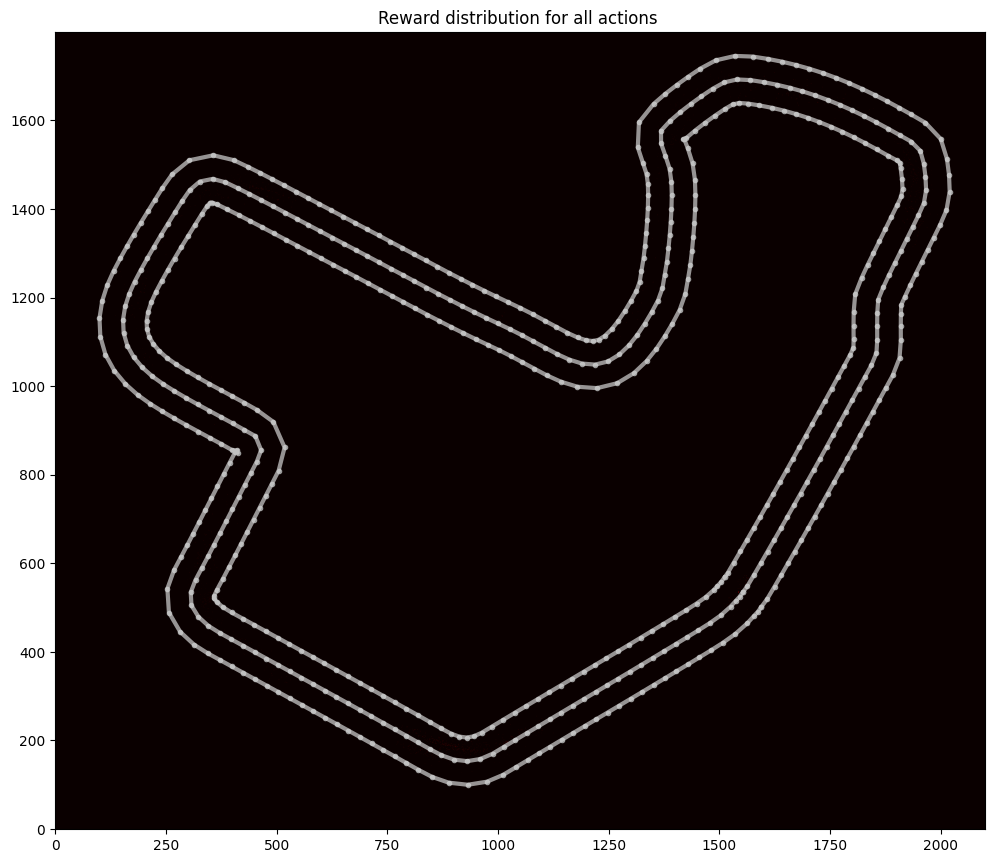

<Figure size 640x480 with 0 Axes>



 Heatmap for action with index 7: steering: -16.0, throttle: 3.2


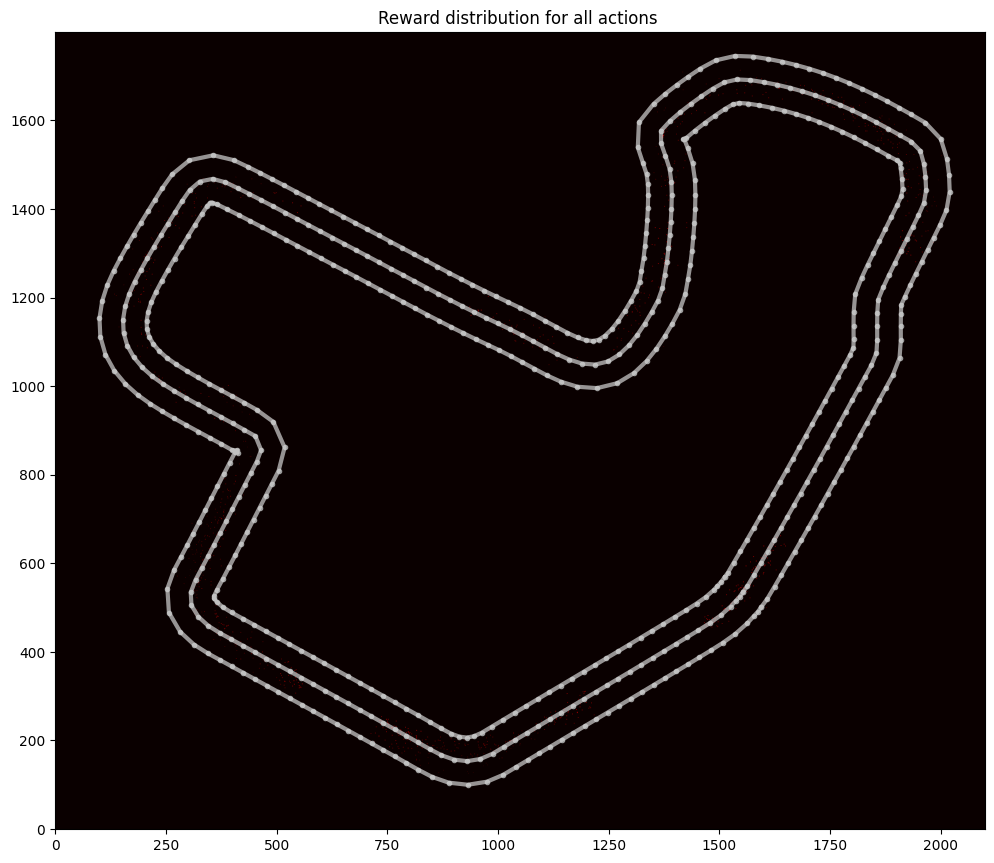

<Figure size 640x480 with 0 Axes>



 Heatmap for action with index 8: steering: -8.0, throttle: 1.1


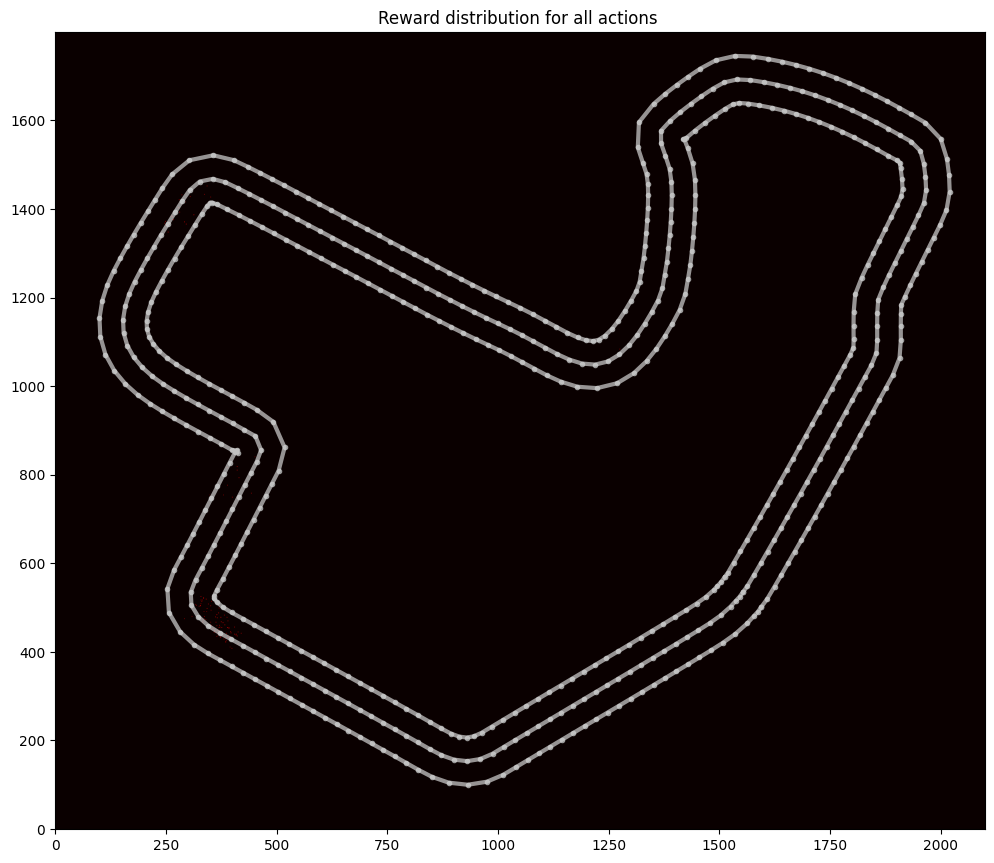

<Figure size 640x480 with 0 Axes>



 Heatmap for action with index 9: steering: -8.0, throttle: 1.8


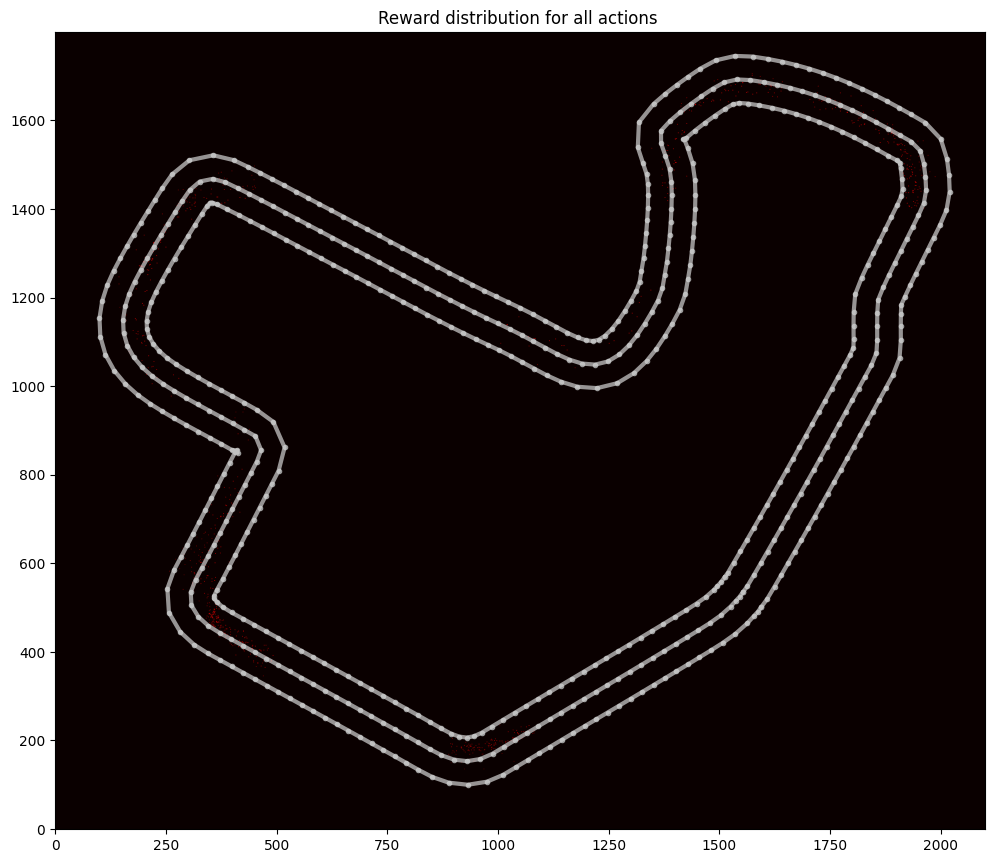

<Figure size 640x480 with 0 Axes>



 Heatmap for action with index 10: steering: -8.0, throttle: 2.5


<Figure size 640x480 with 0 Axes>



 Heatmap for action with index 11: steering: -8.0, throttle: 3.2


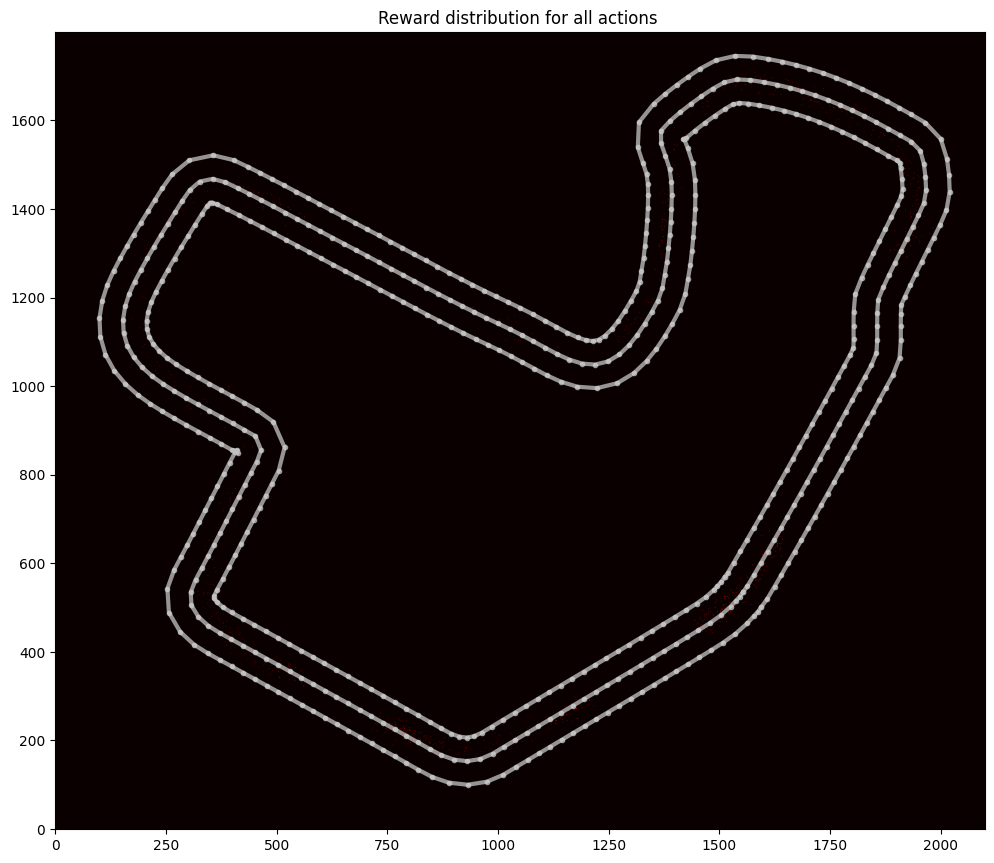

<Figure size 640x480 with 0 Axes>



 Heatmap for action with index 12: steering: -8.0, throttle: 3.8


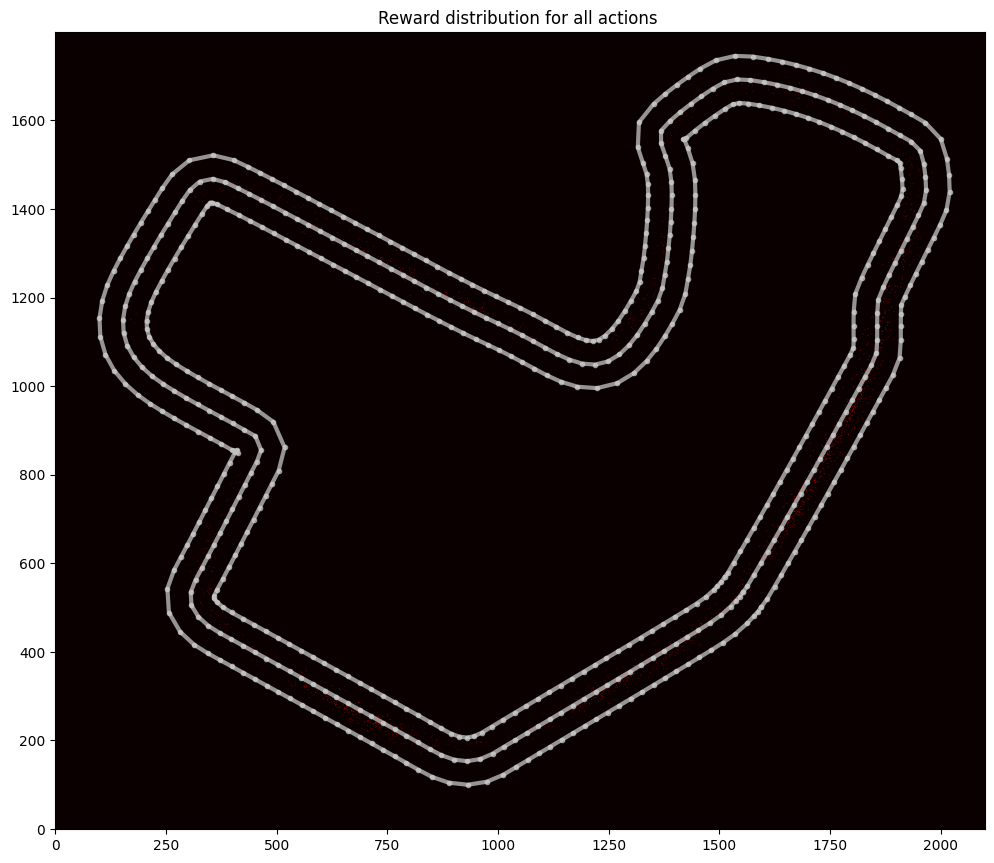

<Figure size 640x480 with 0 Axes>



 Heatmap for action with index 13: steering: 0.0, throttle: 3.8


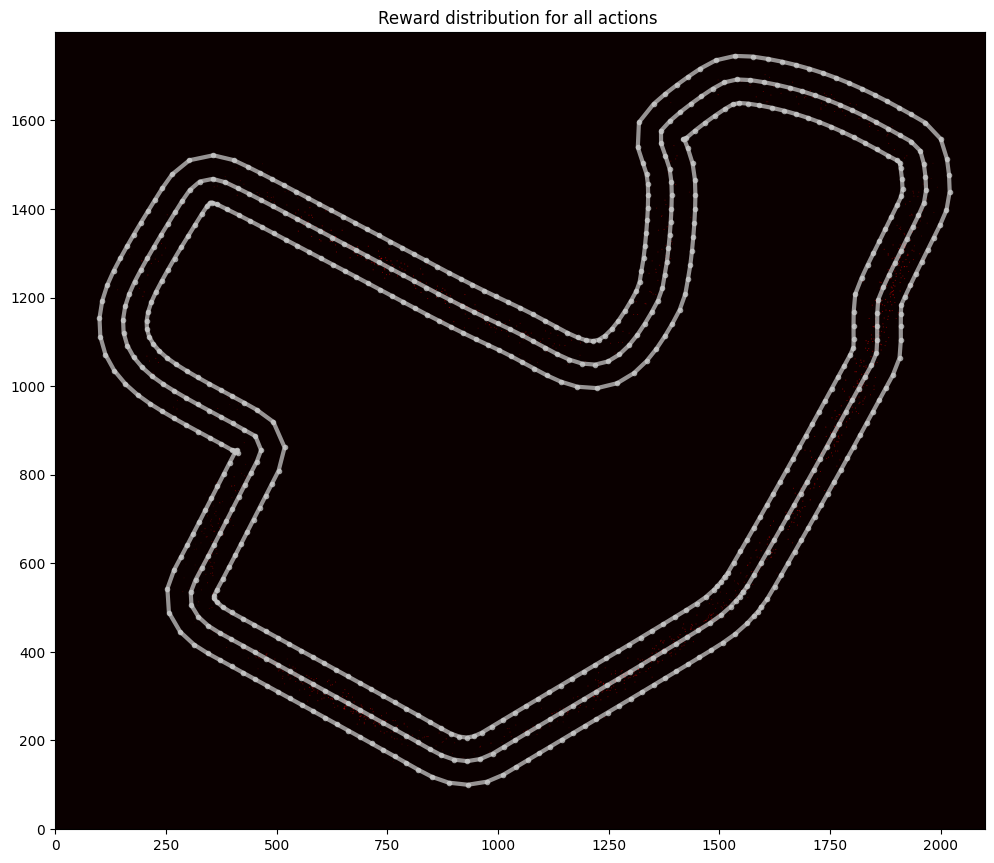

<Figure size 640x480 with 0 Axes>



 Heatmap for action with index 14: steering: 0.0, throttle: 3.2


<Figure size 640x480 with 0 Axes>



 Heatmap for action with index 15: steering: 0.0, throttle: 2.5


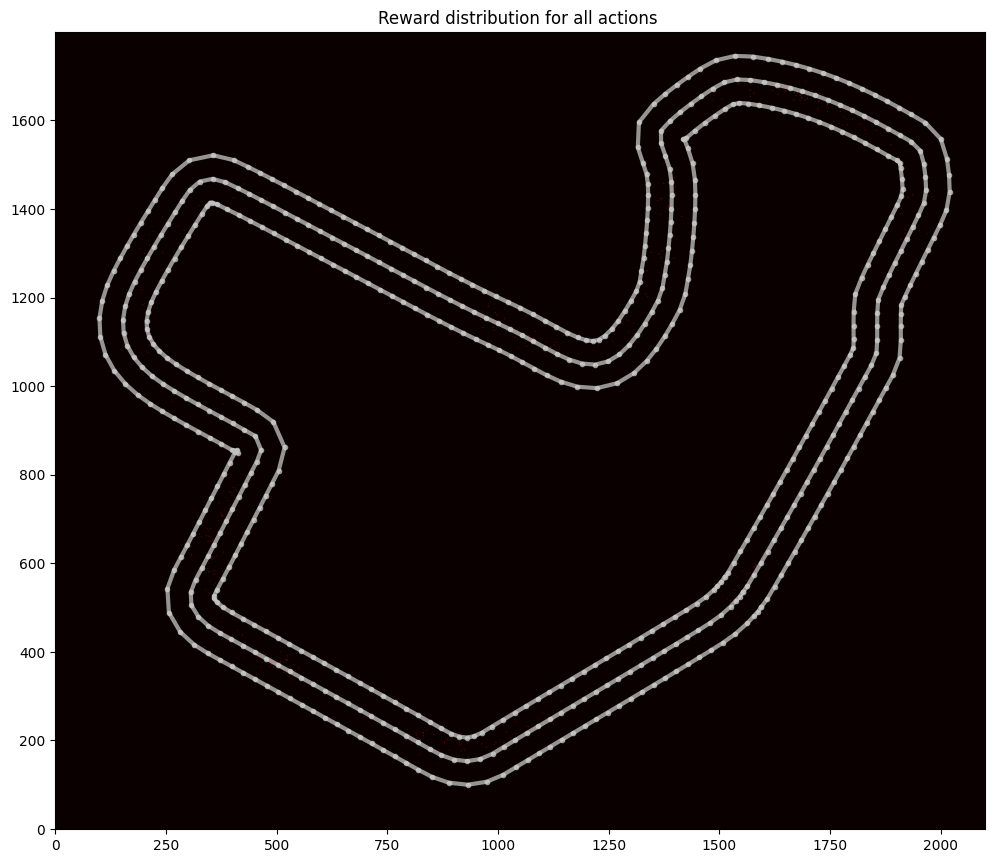

<Figure size 640x480 with 0 Axes>



 Heatmap for action with index 16: steering: 0.0, throttle: 1.8


<Figure size 640x480 with 0 Axes>



 Heatmap for action with index 17: steering: 8.0, throttle: 3.8


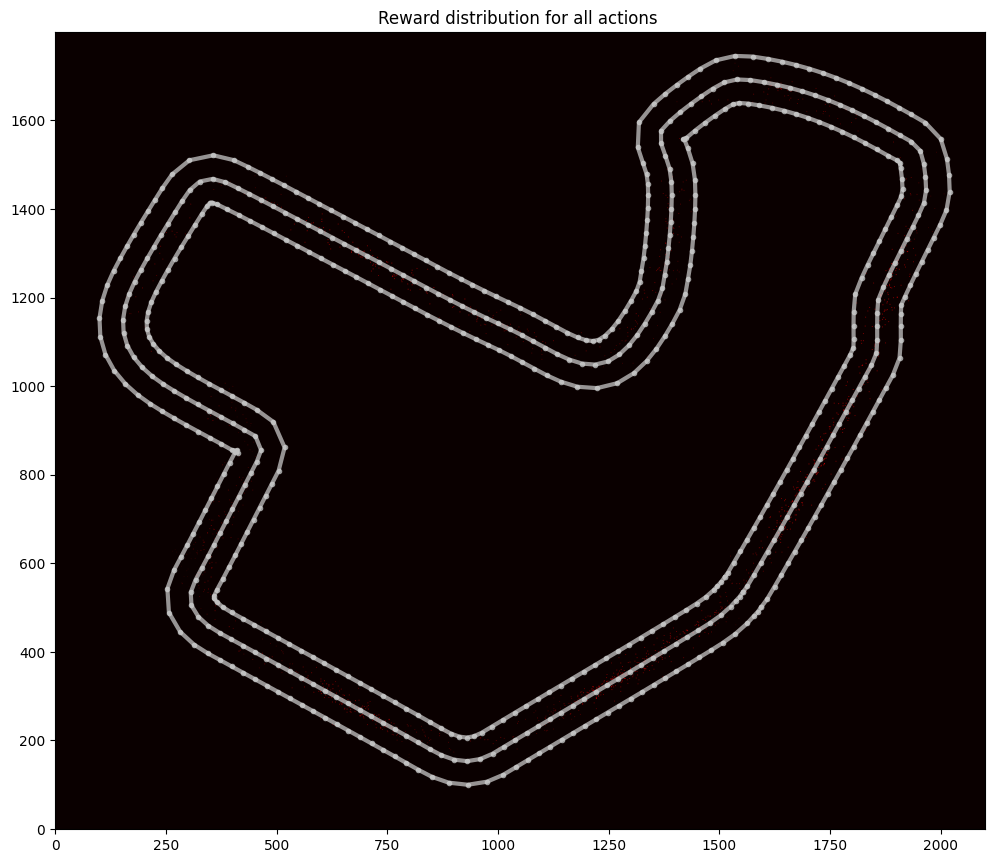

<Figure size 640x480 with 0 Axes>



 Heatmap for action with index 18: steering: 8.0, throttle: 3.2


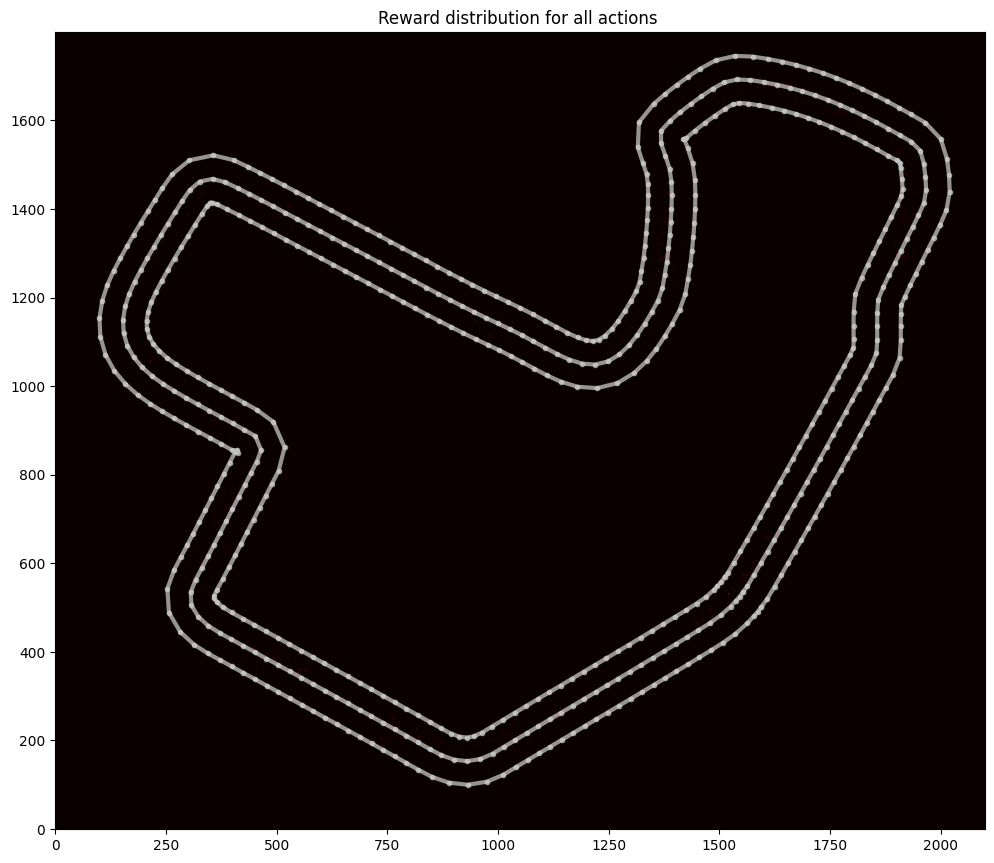

<Figure size 640x480 with 0 Axes>



 Heatmap for action with index 19: steering: 8.0, throttle: 2.5


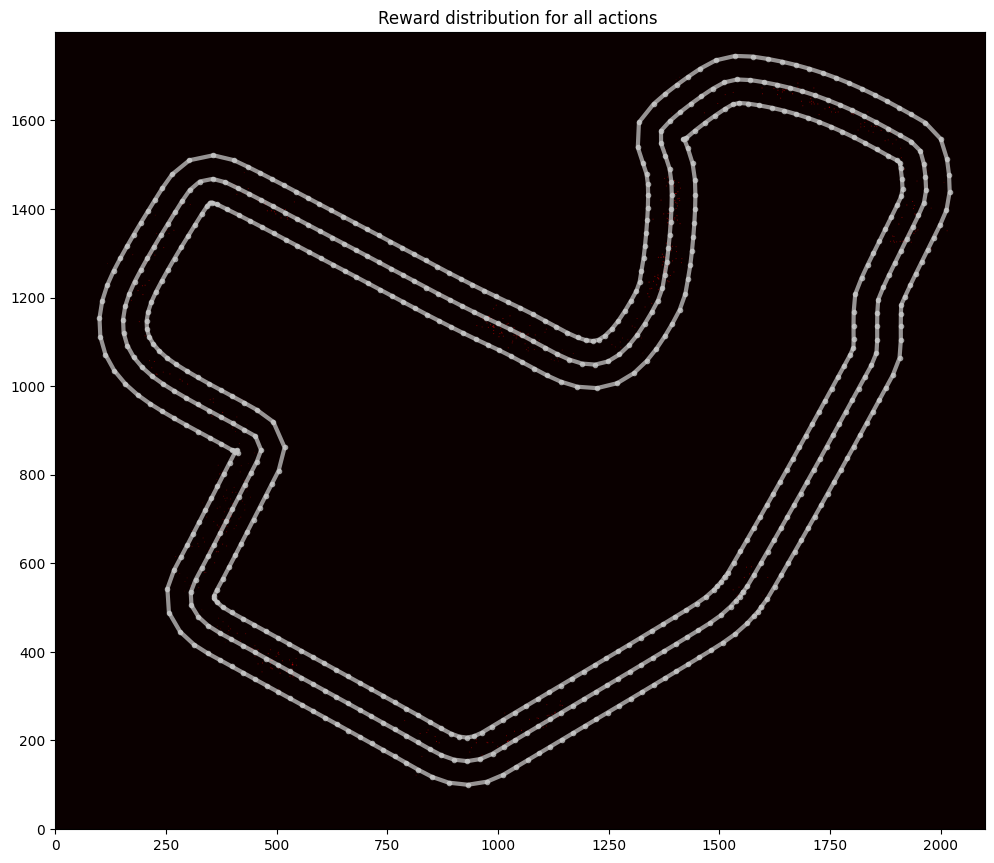

<Figure size 640x480 with 0 Axes>



 Heatmap for action with index 20: steering: 8.0, throttle: 1.8


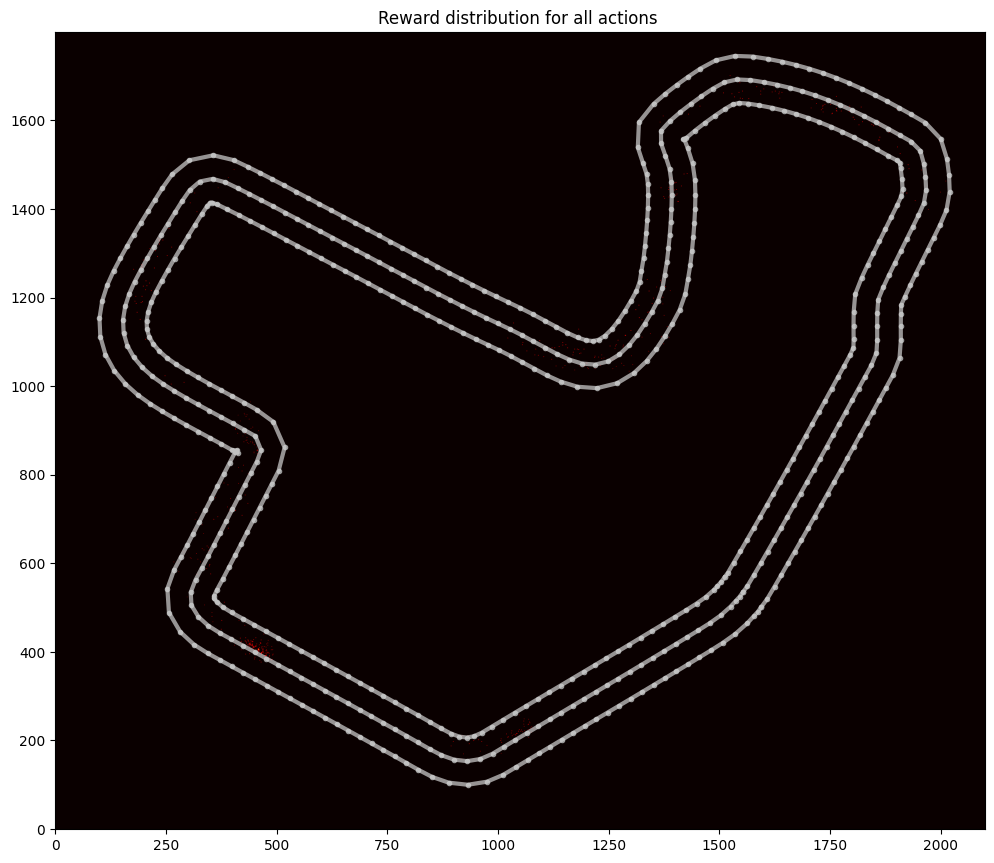

<Figure size 640x480 with 0 Axes>



 Heatmap for action with index 21: steering: 8.0, throttle: 1.1


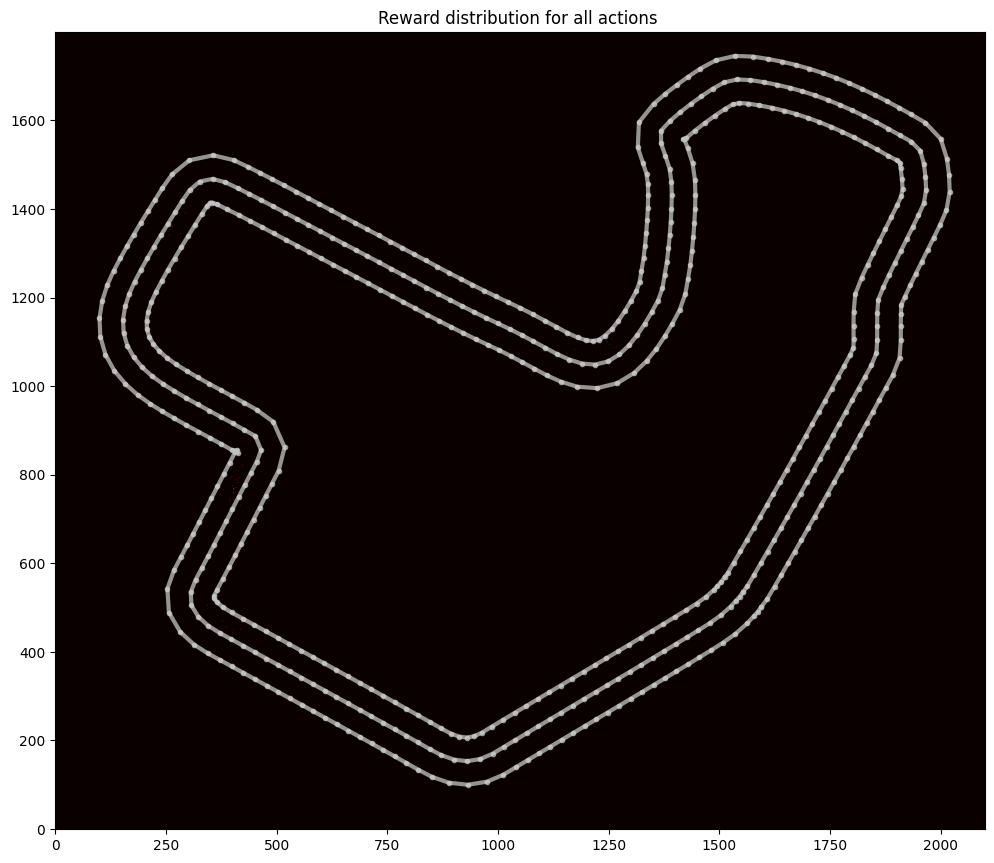

<Figure size 640x480 with 0 Axes>



 Heatmap for action with index 22: steering: 16.0, throttle: 3.2


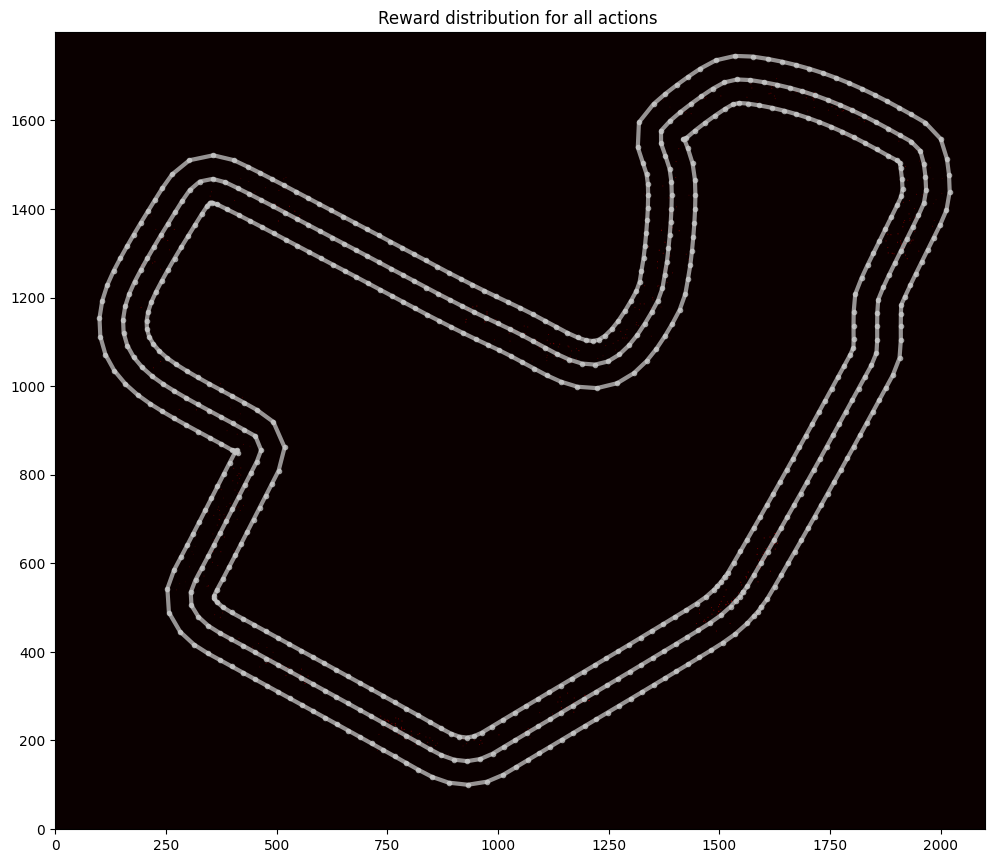

<Figure size 640x480 with 0 Axes>



 Heatmap for action with index 23: steering: 16.0, throttle: 2.5


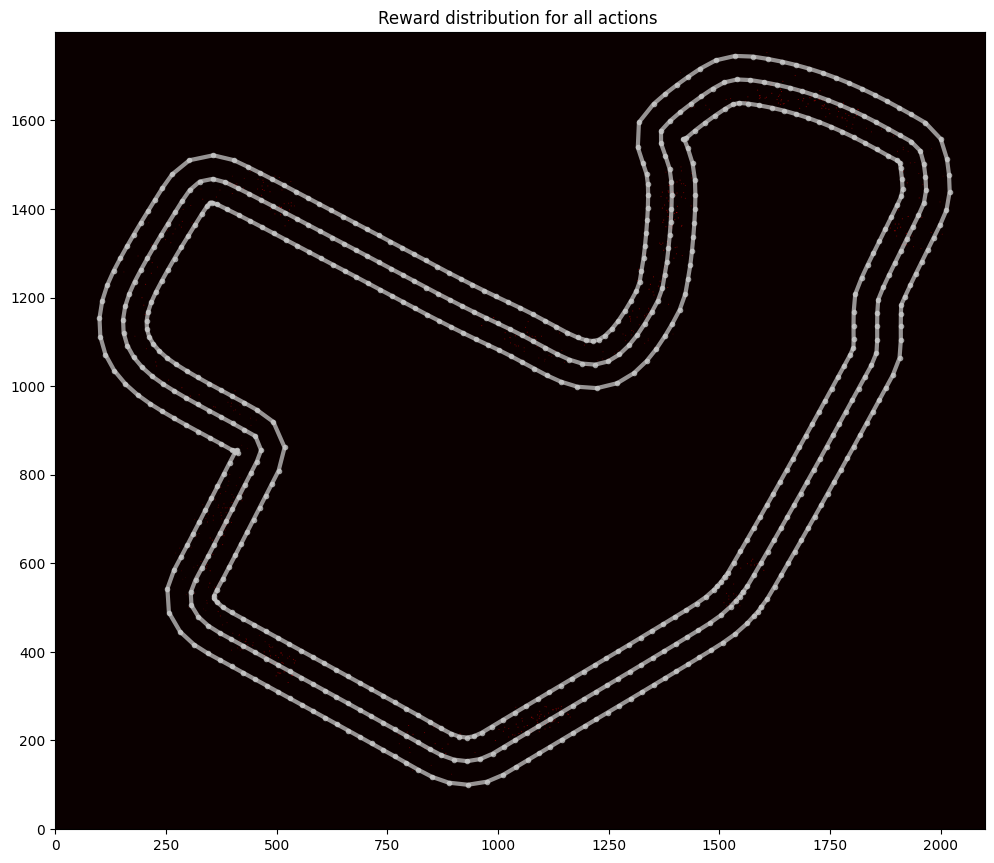

<Figure size 640x480 with 0 Axes>



 Heatmap for action with index 24: steering: 16.0, throttle: 1.8


<Figure size 640x480 with 0 Axes>



 Heatmap for action with index 25: steering: 16.0, throttle: 1.1


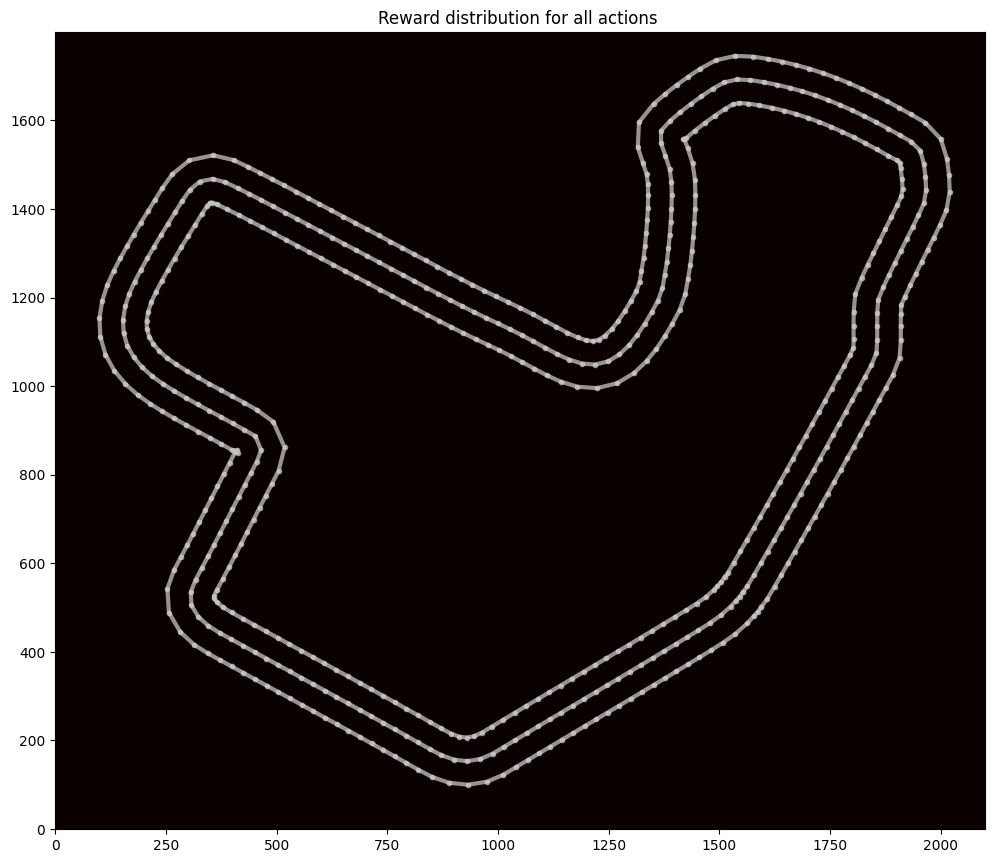

<Figure size 640x480 with 0 Axes>



 Heatmap for action with index 26: steering: 24.0, throttle: 2.5


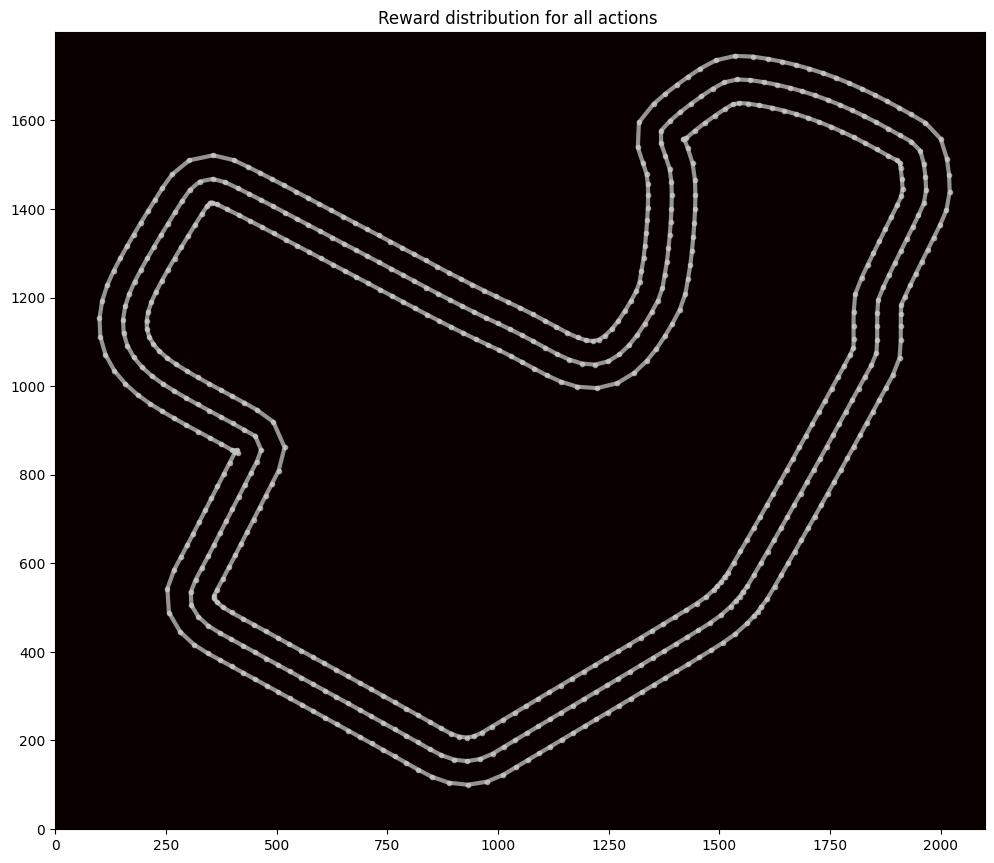

<Figure size 640x480 with 0 Axes>



 Heatmap for action with index 27: steering: 24.0, throttle: 1.8


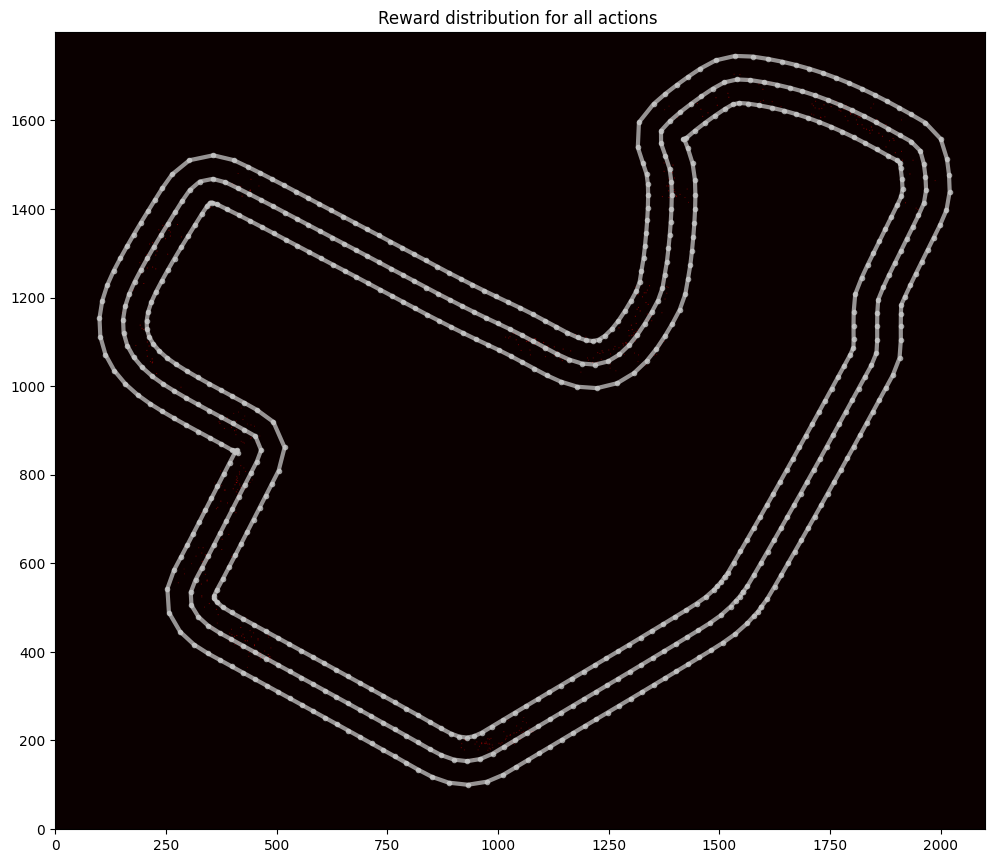

<Figure size 640x480 with 0 Axes>



 Heatmap for action with index 28: steering: 24.0, throttle: 1.1


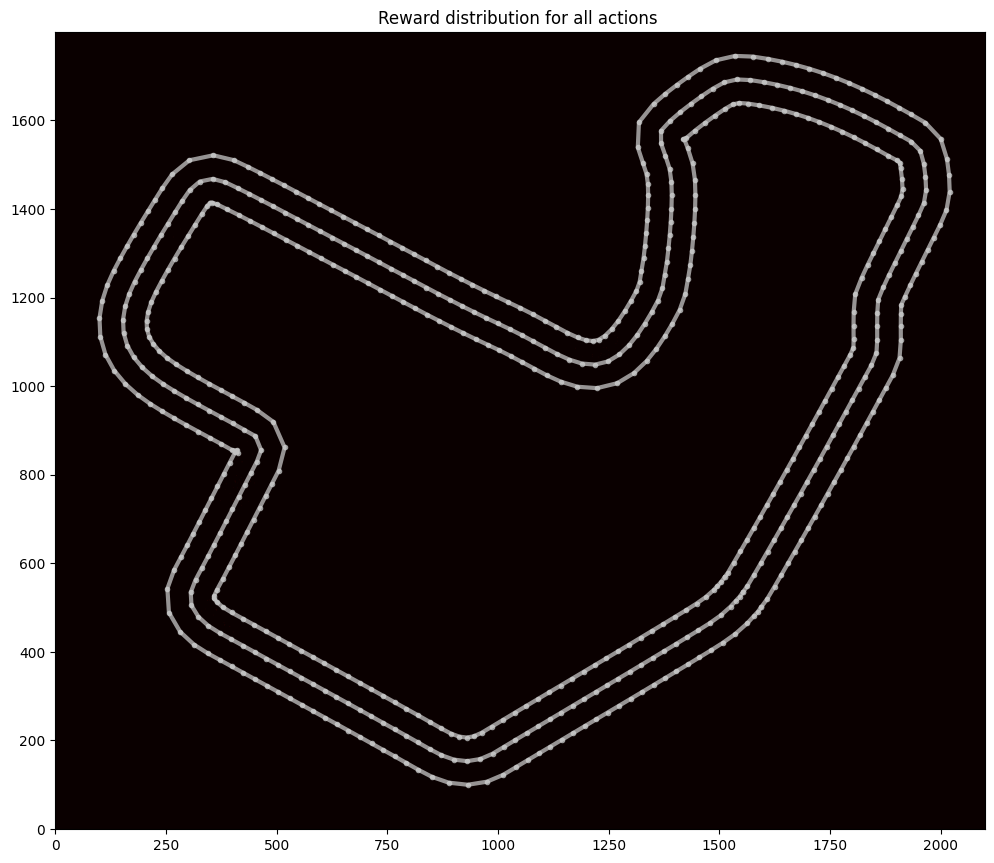

<Figure size 640x480 with 0 Axes>



 Heatmap for action with index 29: steering: 30.0, throttle: 1.1


<Figure size 640x480 with 0 Axes>

In [60]:
aslNum = len(asl)
setActions = range(aslNum)  # show graphs for all Actions
# setActions = (0,1,6,8,9)       # show graphs only for index set Actions
fig = plt.figure(aslNum)
for i in setActions:
    a = asl[i]
    print("\n\n Heatmap for action with index {}: steering: {}, throttle: {}".format(a.index, a.steer, a.throttle))
    tr_plot = pu.plot_track(df[df["action"] == a.index], track, value_field="reward")
    plt.show()